In [1]:
%matplotlib inline

# Applying ST-GAT to Analyze The Breadcrumbs Dataset

## Library and Module Imports

In [2]:
import dgl
import torch
import numpy as np
import importlib
from dgl.dataloading import GraphDataLoader
import os
import pandas as pd
import networkx as nx
import random
from enum import Enum
import csv
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

import dataloader.breadcrumbs_dataloader
import dataloader.splits
import models.st_gat
import models.trainer
import models.persist
import visualizations.attention_matrix
import visualizations.select_significant_pois
import visualizations.predictions
import visualizations.adjacency_matrix

# Reload modules to reflect changes dynamically
importlib.reload(dataloader.breadcrumbs_dataloader)
importlib.reload(dataloader.splits)
importlib.reload(models.st_gat)
importlib.reload(models.trainer)
importlib.reload(models.persist)
importlib.reload(visualizations.attention_matrix)
importlib.reload(visualizations.select_significant_pois)
importlib.reload(visualizations.predictions)
importlib.reload(visualizations.adjacency_matrix)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")
print(f"Version {torch.__version__}")

if not os.path.exists("output"):
    os.makedirs("output")

Using cuda
Version 2.4.0+cu124


## Configuration Settings

Set random seeds for reproducibility.

In [3]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Settings for data preprocessing and evaluation.

In [4]:
config = {
    "BATCH_SIZE": 50,
    "EPOCHS": 30,
    "WEIGHT_DECAY": 5e-5,
    "INITIAL_LR": 4e-5,
    "CHECKPOINT_DIR": "./trained_models/Predicting_Breadcrumbs_Movement",
    "N_PRED": 9,
    "N_HIST": 24,
    "DROPOUT": 0.3,
    "SLOTS_PER_DAY": 24,
}

The location of the checkpointed model for inference.

In [5]:
checkpoint_name = "finetune_testing_pred9/stage2_9epochs_5e-5.pt"

## Data Proprocessing

Generated 2285 different graphs from the normalized timeseries data each with the same 651 nodes and 228363 edges.
Completed Data Preprocessing.


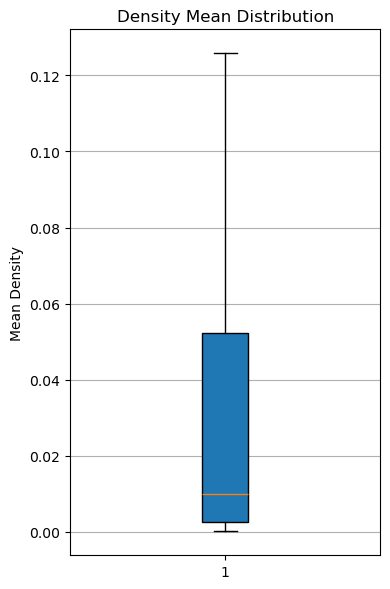

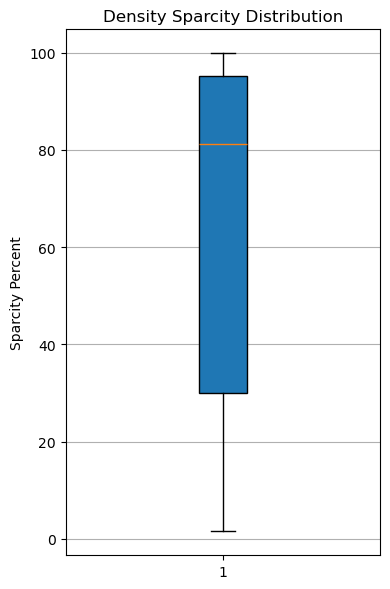

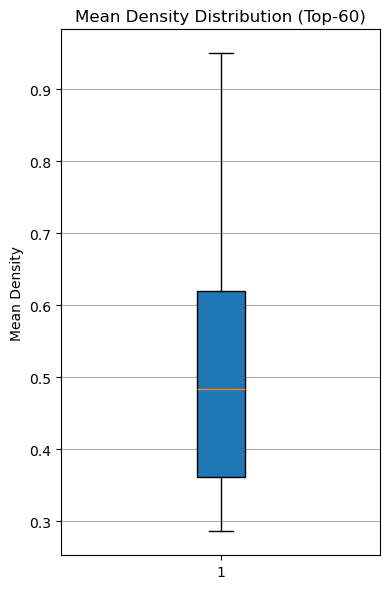

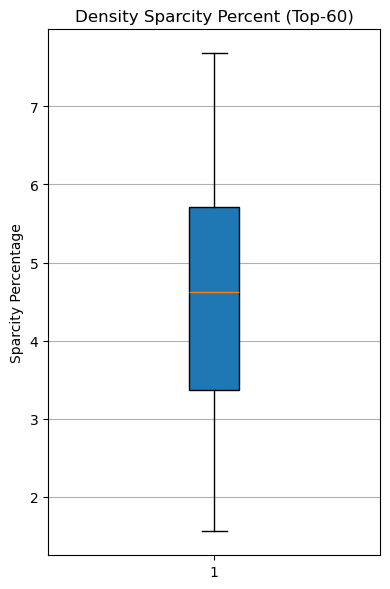

In [6]:
# Preprocess the input graph structure and timeseries data, splitting into train, validation and test sets
dataset, config["D_MEAN"], config["D_STD_DEV"], d_train, d_val, d_test = (
    dataloader.breadcrumbs_dataloader.get_processed_dataset(config)
)
print("Completed Data Preprocessing.")

# Build the test set DGL dataloader
test_dataloader = GraphDataLoader(
    d_test, batch_size=config["BATCH_SIZE"], shuffle=False
)

# Dynamically define the number of nodes and edges in the processed graph
config["N_NODES"] = dataset.graphs[0].number_of_nodes()
config["N_EDGES"] = dataset.graphs[0].number_of_edges()

## Logistic Weighting Function

The following graph visualizes the logistic weighting function used to generate the participant densities at each point of interest for each hour time period.

POI significance chart saved at ./output/logistic_weighting_function.png


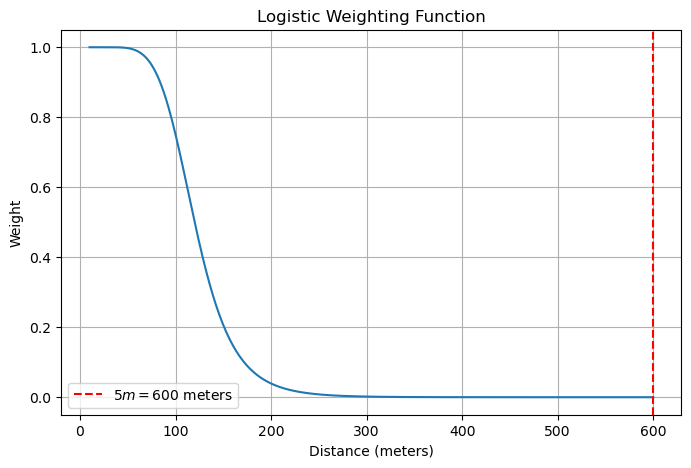

In [7]:
# Constants
m = 0.120  # cutoff distance in km
s = 3 / m  # slope factor

# Distance range (avoid division by zero)
d_values = np.linspace(0.01, 0.6, 500)
f_values = 1 / (1 + np.exp(-s * (m**2 / d_values - d_values)))

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(d_values * 1000, f_values)
plt.axvline(x=5 * m * 1000, color='red', linestyle='--', label=f"$5m = {5*m*1000:.0f}$ meters")
plt.title("Logistic Weighting Function")
plt.xlabel("Distance (meters)")
plt.ylabel("Weight")
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.legend()
location = "./output/logistic_weighting_function.png"
plt.savefig(location, bbox_inches="tight")
print(f"POI significance chart saved at {location}")

## Load the Checkpointed Model

In [8]:
if checkpoint_name is None or checkpoint_name == "":
    print(f"ERROR: Must input a valid checkpoint file for 'checkpoint_name' variable.")
    exit()

checkpoint_path = os.path.join(config["CHECKPOINT_DIR"], checkpoint_name)

if not os.path.exists(checkpoint_path):
    print(f"ERROR: Checkpoint file {checkpoint_path} does not exist.")
    exit()

print(f"Loading checkpoint found at {checkpoint_path}")
checkpoint = torch.load(checkpoint_path, weights_only=False, map_location=torch.device(device))

model = models.st_gat.ST_GAT(
    in_channels=config["N_HIST"],
    out_channels=config["N_PRED"],
    n_nodes=config["N_NODES"],
    dropout=config["DROPOUT"],
)

model.load_state_dict(checkpoint["model_state_dict"])

print(
    f"The loaded model trained for {checkpoint['epoch']} epochs and resulted in a the following metrics:"
)
print(f"\tLoss: {checkpoint['loss']}")
print(f"\tTrain MAE: {checkpoint['train_mae']}")
print(f"\tTrain RMSE: {checkpoint['train_rmse']}")
print(f"\tValidation MAE: {checkpoint['val_mae']}")
print(f"\tValidation RMSE: {checkpoint['val_rmse']}")

epoch = checkpoint["epoch"]

Loading checkpoint found at ./trained_models/Predicting_Breadcrumbs_Movement/finetune_testing_pred9/stage2_9epochs_5e-5.pt
The loaded model trained for 49 epochs and resulted in a the following metrics:
	Loss: 0.39788663387298584
	Train MAE: 0.07503674924373627
	Train RMSE: 0.21814937889575958
	Validation MAE: 0.08825156837701797
	Validation RMSE: 0.2523934841156006


## Run Inference on the Test Data

In [9]:
# NOTE If you are running on a CPU on unity, this will take 1-2 minutes
_, _, _, y_pred, y_truth, _ = models.trainer.model_test(
    model, test_dataloader, device, config
)

Test, MAE: 0.0838363915681839, RMSE: 0.22727584838867188, MAPE: 58.807735443115234


Compute the average attention matrix over all training data timesteps.

In [10]:
attention = np.zeros((config["N_NODES"], config["N_NODES"]))

for i in range(len(d_train)):
    graph = d_train[i].to(device)
    a = models.trainer.model_test_get_attention(model, graph, device, config)
    attention += a
attention /= len(d_train)
np.save("output/attention.npy", attention)

## Compute Point of Interest Significance

POI significance chart saved at ./output/poi_significance.png
Significant POIs:
[   10    33     1    58     2     9     6 10404     5     7    50    14
    13   102     3 11958    27 10403    29   106    25    35     8   196
    15    49    51   118    80    41   105   107    79 11913    28    36
    30    11   136    17    48    86    23    18   127   111    53 10106
   147   148 11405    59 10783    12    16    95    40 10863 11397    76]
Corresponding Scores:
[3.42556085 3.05343409 2.8758224  2.18388245 2.17796772 1.86203793
 1.79990957 1.64423957 1.26054649 1.23769827 1.22510194 1.16545322
 0.98643659 0.94822645 0.93362333 0.92615404 0.88501056 0.8163995
 0.79955551 0.78830984 0.78375174 0.71961744 0.71580492 0.6959409
 0.69374112 0.68452315 0.65797477 0.65229655 0.64469699 0.62910931
 0.57572409 0.55795944 0.55426934 0.54138604 0.53835725 0.53084769
 0.53081401 0.51233489 0.50606503 0.50292088 0.49602482 0.46049405
 0.45865363 0.45787394 0.45423368 0.45011698 0.44527773 0.4434154

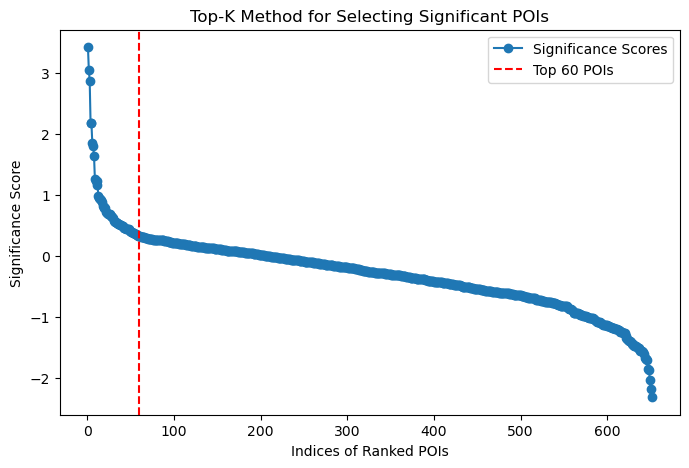

In [11]:
n_top_pois = 60

significant_pois, sorted_scores, sorted_indices = (
    visualizations.select_significant_pois.get_significant_pois(
        attention, dataset.graphs[0].ndata["id"], n_top_pois, plot=True, transform=np.log
    )
)

print(f"Significant POIs:\n{significant_pois}")
print(f"Corresponding Scores:\n{sorted_scores}")

## Visualize the Adjacency and Attention Matrices

Plot the full adjacency matrix.

Adjacency matrix plot saved to ./output/adj_mtx.png


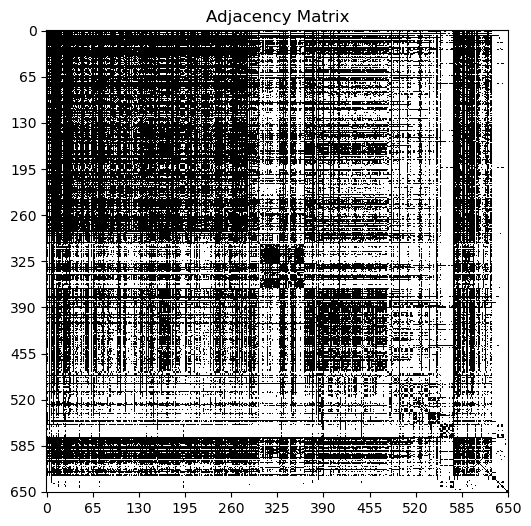

In [12]:
G = nx.read_adjlist("dataset/pruned_clustered_3hop_graph.adjlist")
adj_mtx = nx.to_numpy_array(G)
visualizations.adjacency_matrix.plot_adjacency_matrix(
    adj_mtx, "./output/adj_mtx.png"
)

Plot the adjacency matrix of the subgraph made up from the top n points of interest.

Adjacency matrix plot saved to ./output/subgraph_adj_mtx.png


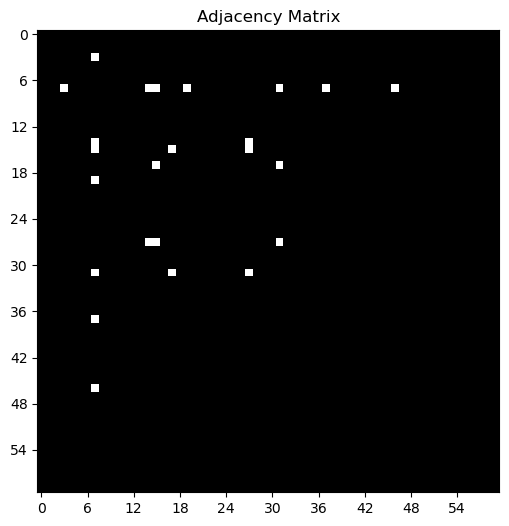

In [13]:
subgraph_adj_mtx = visualizations.adjacency_matrix.get_subgraph(
    adj_mtx, sorted_indices[:n_top_pois]
)
visualizations.adjacency_matrix.plot_adjacency_matrix(
    subgraph_adj_mtx, "./output/subgraph_adj_mtx.png"
)

Plot the heatmap of the averaged attention matrix over all training timesteps.

Attention heat map saved to ./output/attention_heatmap_epoch49.png


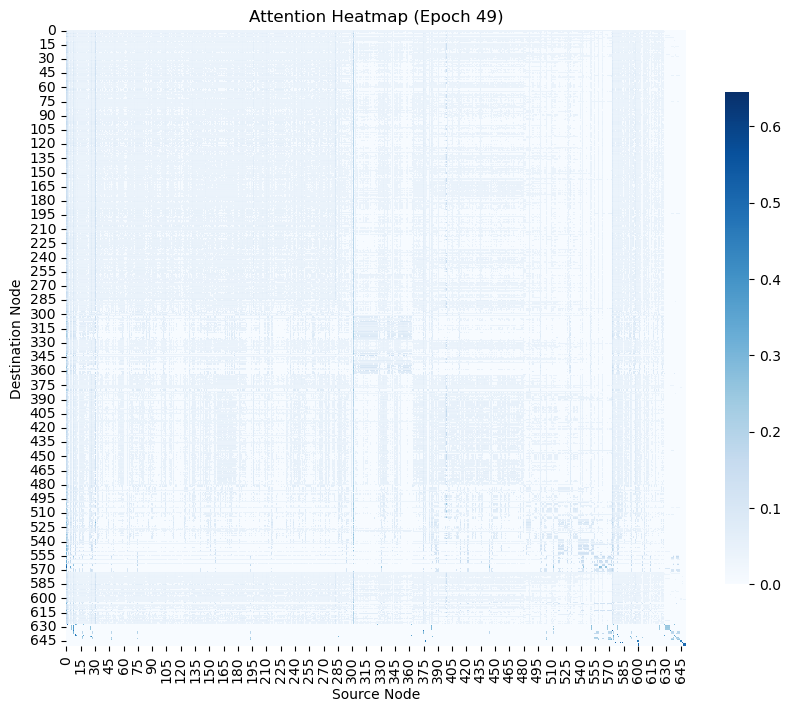

In [14]:
visualizations.attention_matrix.plot_heatmap(
    attention, epoch, transform=lambda x: x ** (1/2)
)

Now repeat but with the top-n node subset.

Attention heat map saved to ./output/attention_heatmap_epoch49.png


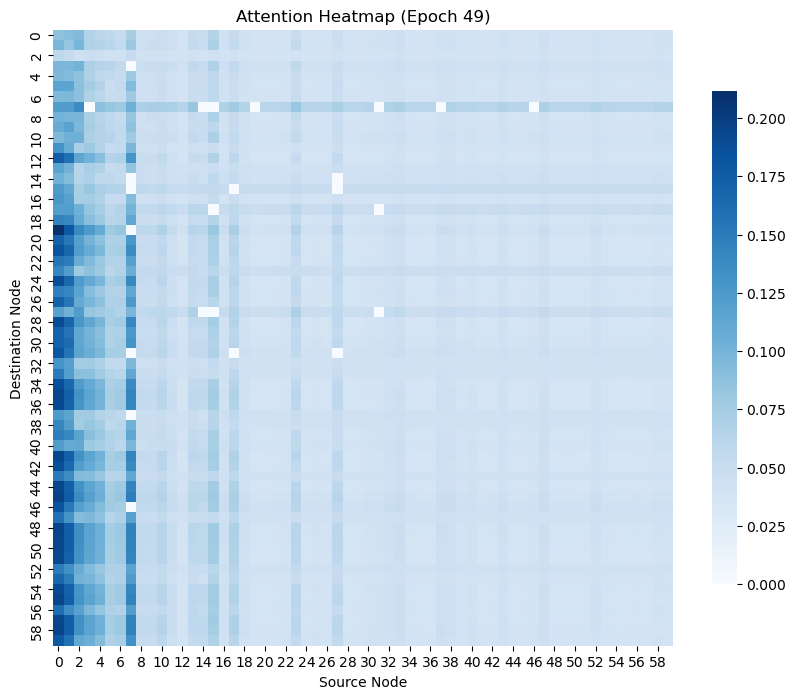

In [15]:
subgraph_attention = visualizations.adjacency_matrix.get_subgraph(
    attention, sorted_indices[:n_top_pois]
)
visualizations.attention_matrix.plot_heatmap(
    subgraph_attention, epoch, transform=lambda x: x ** (1/2)
)

Reconstruct an adjacency matrix based on a threshold of the attention matrix.

Adjacency matrix plot saved to ./output/reconstructed_adjacency.png
Correctly Predicted Edges: 1620
Total Predicted Edges: 27441
Total True Edges: 10079
Precision: 5.90%
Recall: 16.07%


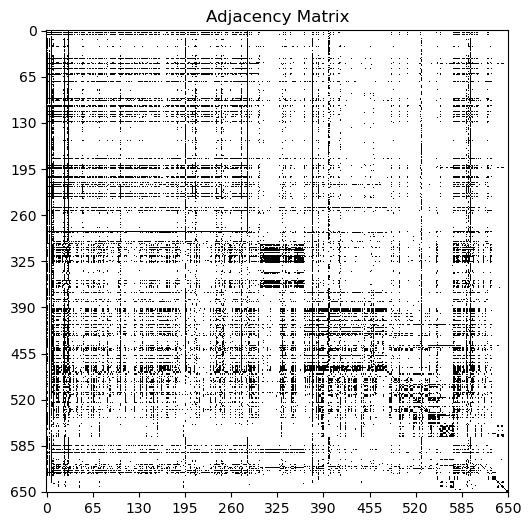

In [68]:
attention_root = np.log1p(attention)
attention_mean = np.mean(attention)
attention_std = np.std(attention)
threshold = attention_mean + (attention_std * 1/4)
reconstructed_adjacency = (attention > threshold).astype(int)
reconstructed_adjacency = (reconstructed_adjacency > 0).astype(int)
visualizations.adjacency_matrix.plot_adjacency_matrix(
    reconstructed_adjacency, "./output/reconstructed_adjacency.png"
)

# Read the original graph without any hop extensions or pruning
G1 = nx.read_adjlist("dataset/clustered_G1Hops.adjlist")
# Read in the pruned 3-hop graph
G2 = nx.read_adjlist("dataset/pruned_clustered_3hop_graph.adjlist")

# Keep only the nodes in the original graph that are in the pruned 3-hop graph
common_nodes = set(G1.nodes()).intersection(G2.nodes())
G = G1.subgraph(common_nodes).copy()

node_ids = list(G.nodes())
original_adjacency = nx.to_numpy_array(G, nodelist=node_ids)
original_adjacency = (original_adjacency).astype(int)

# Count total matching edges (where both have 1s)
matching_edges = np.sum((original_adjacency == 1) & (reconstructed_adjacency == 1))

# Total predicted and actual edges
total_true = np.sum(original_adjacency)
total_pred = np.sum(reconstructed_adjacency)

# Since each edge is counted twice in undirected graphs, divide by 2
matching_edges //= 2
total_true //= 2
total_pred //= 2

# Precision and recall
precision = matching_edges / total_pred if total_pred > 0 else 0
recall = matching_edges / total_true if total_true > 0 else 0

print(f"Correctly Predicted Edges: {matching_edges}")
print(f"Total Predicted Edges: {total_pred}")
print(f"Total True Edges: {total_true}")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")

Now analyze the reconstruction up close with the sub-graph of the top-n nodes.

Adjacency matrix plot saved to ./output/reconstructed_adjacency_subgraph.png
Adjacency matrix plot saved to ./output/reconstructed_adjacency_subgraph.png


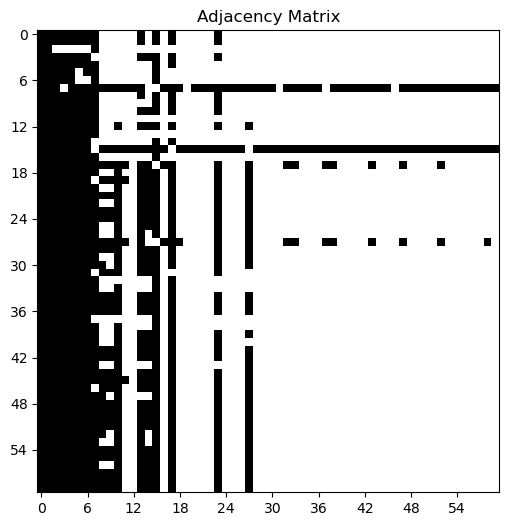

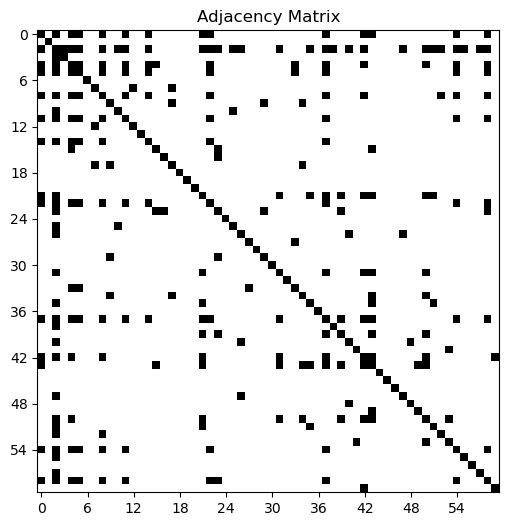

In [65]:
subgraph_attention = visualizations.adjacency_matrix.get_subgraph(
    reconstructed_adjacency, sorted_indices[:n_top_pois]
)
subgraph_original = visualizations.adjacency_matrix.get_subgraph(
    original_adjacency, sorted_indices[:n_top_pois]
)
visualizations.adjacency_matrix.plot_adjacency_matrix(
    subgraph_attention, "./output/reconstructed_adjacency_subgraph.png"
)
visualizations.adjacency_matrix.plot_adjacency_matrix(
    subgraph_original, "./output/reconstructed_adjacency_subgraph.png"
)

## Predictions and Anomaly Detection

In [16]:
# Will tag anomaly if:
# truth[i] - prediction[i] > anomaly_threshold_multiplier * mean(truth - prediction)
anomaly_threshold_multiplier = 5

### Plot the Predictions and Anomalies for a Single Point of Interest by Cluster ID

Prediction visualization for node 30 saved to ./output/rank36_node30_predicted_densities.png
Index(['2018-03-28 00:00:00', '2018-03-30 08:00:00', '2018-04-02 11:00:00',
       '2018-04-06 23:00:00', '2018-04-10 10:00:00', '2018-04-10 12:00:00',
       '2018-04-10 13:00:00', '2018-04-10 14:00:00'],
      dtype='object', name='timestamp')


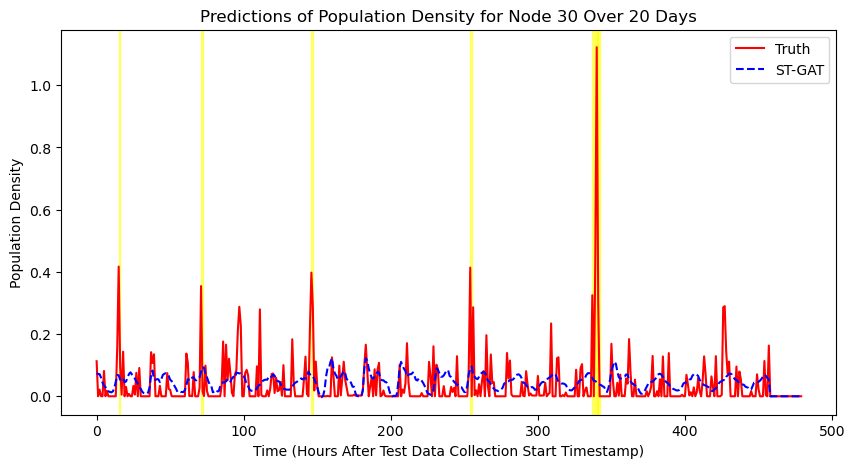

In [17]:
# NOTE Set this to True to plot all 9 hours of predictions
# If False, it will just plot the first hour of each prediction
full_prediction_plot = False
# The node cluster ID to analyze
cluster_id = 30

def plot_predictions_for_poi_cluster(id):
    """Plot the predictions for the POI in cluster labelled `id`
    
    Highlight in yellow anomalies where the ground truth is either
    abnormally higher or lower than the predictions for one hour ahead

    Args:
        id (_type_): The cluster id for the point of interest
    """
    cluster_ids = dataset.graphs[0].ndata["id"].tolist()
    cluster_index = cluster_ids.index(id)
    rank = np.argwhere(significant_pois == id).squeeze() if id in significant_pois else -1
    
    f = visualizations.predictions.plot_prediction if full_prediction_plot is False else visualizations.predictions.plot_prediction_full
    anomaly_indices = f(
        test_dataloader,
        y_pred,
        y_truth,
        cluster_index,
        id,
        rank,     # Assigns a rank of -1 if not within the n_top_pois
        config,
        anomaly_threshold_multiplier=anomaly_threshold_multiplier
    )
    dt_index = dataset.graph_timestamps[anomaly_indices]
    anomaly_timestamps = pd.to_datetime(dt_index, format="%Y-%m-%dT-%H-%M").astype(str)
    return anomaly_timestamps, anomaly_indices

anomaly_timestamps, anomaly_indices = plot_predictions_for_poi_cluster(cluster_id)
print(anomaly_timestamps)

### Visualize Attention Matrices for Each Anomaly of the Selected Cluster ID

In [18]:
attention_matrices = {}

for i in range(len(anomaly_indices)):
    index = anomaly_indices[i]
    date = anomaly_timestamps[i]
    anomalous_graph = d_test[i].to(device)
    a = models.trainer.model_test_get_attention(model, anomalous_graph, device, config)
    attention_matrices[f"{date} (Hour {index})"] = a

# Create a dropdown widget for selecting the time step
dropdown = widgets.Dropdown(
    options=attention_matrices.keys(),
    description="Anomaly:",
    disabled=False,
)

# Function to update heatmap based on dropdown selection
def update_heatmap(selected_time_step):
    attn_matrix = attention_matrices.get(selected_time_step)
    if attn_matrix is not None:
        subgraph_attn_mtx = visualizations.adjacency_matrix.get_subgraph(
            attn_matrix, sorted_indices[:n_top_pois]
        )
        print(subgraph_attn_mtx)
        visualizations.attention_matrix.plot_heatmap(
            subgraph_attn_mtx, epoch, transform=lambda x: x ** (1/2)
        )
    else:
        print(f"No attention matrix available for time step {selected_time_step}")

# Link the dropdown to the function
widgets.interactive(update_heatmap, selected_time_step=dropdown)

interactive(children=(Dropdown(description='Anomaly:', options=('2018-03-28 00:00:00 (Hour 15)', '2018-03-30 0…

Now plot attention values over test time.

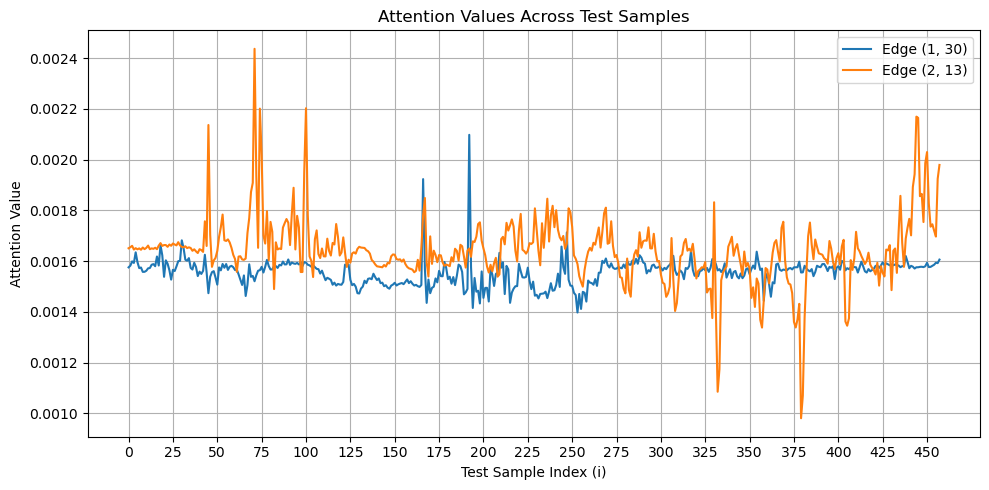

In [26]:
# Cluster IDs of node edges to graph, add more here
edges = [(1, 30), (2, 13)]
values = [[] for _ in edges]  # One list per edge

for i in range(len(d_test)):
    graph = d_train[i].to(device)
    a = models.trainer.model_test_get_attention(model, graph, device, config)
    
    for idx, (src, dest) in enumerate(edges):
        # Get index of src and dest
        src_index = sorted_indices[np.where(significant_pois == src)[0][0]]
        dest_index = sorted_indices[np.where(significant_pois == dest)[0][0]]
        
        values[idx].append(a[src_index][dest_index])

# Plot the values
plt.figure(figsize=(10, 5))
for idx, edge_values in enumerate(values):
    plt.plot(range(len(edge_values)), edge_values, label=f"Edge {edges[idx]}")

plt.xlabel("Test Sample Index (i)")
plt.ylabel("Attention Value")
plt.title("Attention Values Across Test Samples")
plt.legend()
plt.grid(True)

# Add x-axis ticks every 25 steps
plt.xticks(ticks=range(0, len(d_test), 25))

plt.tight_layout()
plt.show()


### Plot the Predictions and Anomalies for Top-N Ranked Points of Interest

Prediction visualization for node 10 saved to ./output/rank0_node10_predicted_densities.png
Prediction visualization for node 33 saved to ./output/rank1_node33_predicted_densities.png
Prediction visualization for node 1 saved to ./output/rank2_node1_predicted_densities.png
Prediction visualization for node 58 saved to ./output/rank3_node58_predicted_densities.png
Prediction visualization for node 2 saved to ./output/rank4_node2_predicted_densities.png
Prediction visualization for node 9 saved to ./output/rank5_node9_predicted_densities.png
Prediction visualization for node 6 saved to ./output/rank6_node6_predicted_densities.png
Prediction visualization for node 10404 saved to ./output/rank7_node10404_predicted_densities.png
Prediction visualization for node 5 saved to ./output/rank8_node5_predicted_densities.png
Prediction visualization for node 7 saved to ./output/rank9_node7_predicted_densities.png
Prediction visualization for node 50 saved to ./output/rank10_node50_predicted_densiti

/work/pi_hongkunz_umass_edu/dgerard/GATMobilityAnalysis/visualizations/predictions.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))


Prediction visualization for node 35 saved to ./output/rank21_node35_predicted_densities.png
Prediction visualization for node 8 saved to ./output/rank22_node8_predicted_densities.png
Prediction visualization for node 196 saved to ./output/rank23_node196_predicted_densities.png
Prediction visualization for node 15 saved to ./output/rank24_node15_predicted_densities.png
Prediction visualization for node 49 saved to ./output/rank25_node49_predicted_densities.png
Prediction visualization for node 51 saved to ./output/rank26_node51_predicted_densities.png
Prediction visualization for node 118 saved to ./output/rank27_node118_predicted_densities.png
Prediction visualization for node 80 saved to ./output/rank28_node80_predicted_densities.png
Prediction visualization for node 41 saved to ./output/rank29_node41_predicted_densities.png
Prediction visualization for node 105 saved to ./output/rank30_node105_predicted_densities.png
Prediction visualization for node 107 saved to ./output/rank31_nod

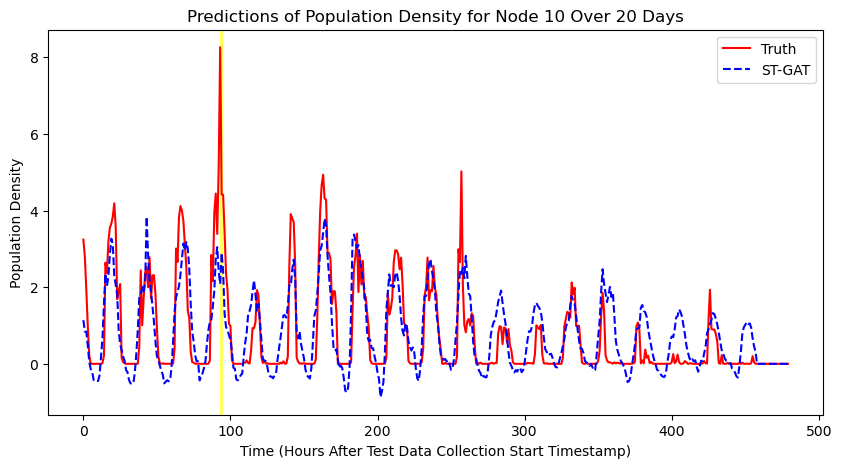

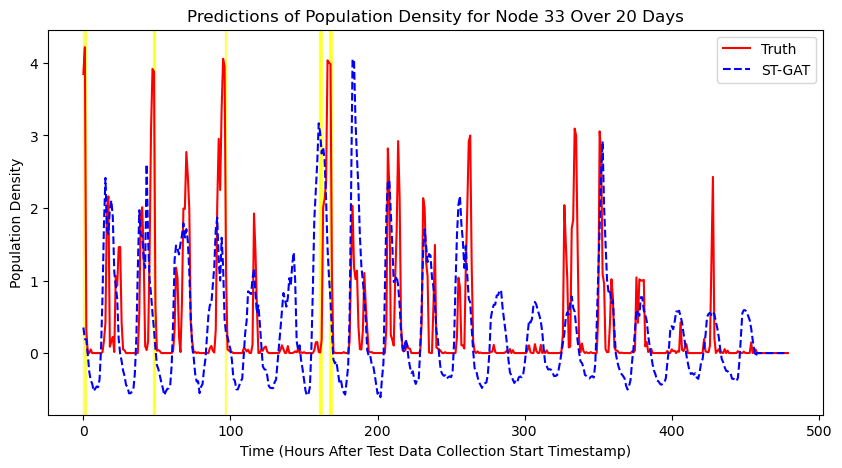

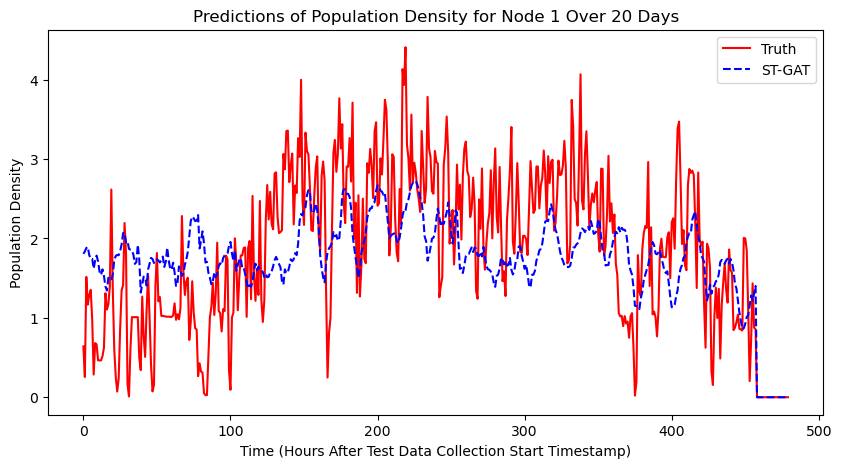

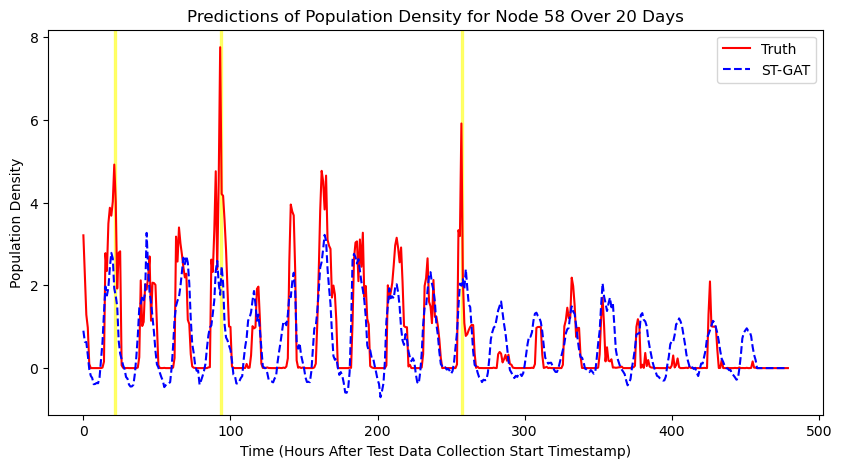

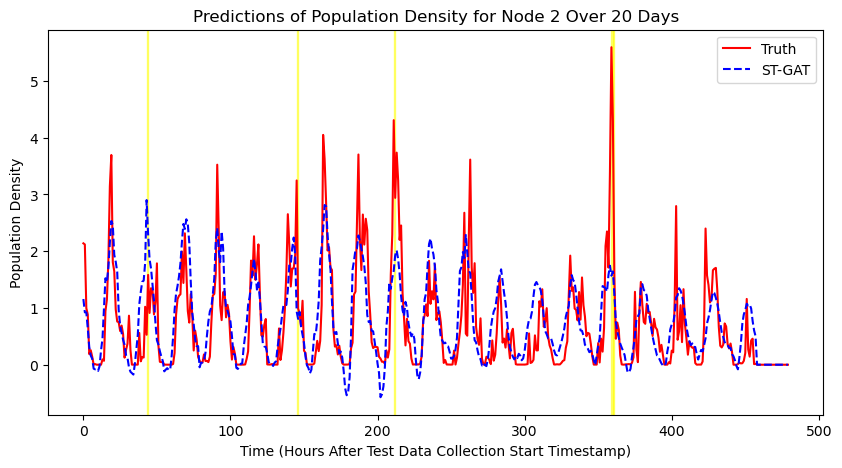

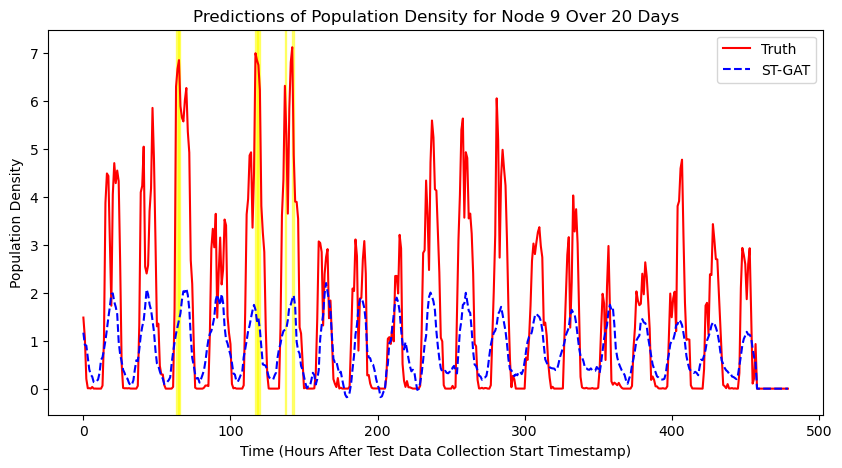

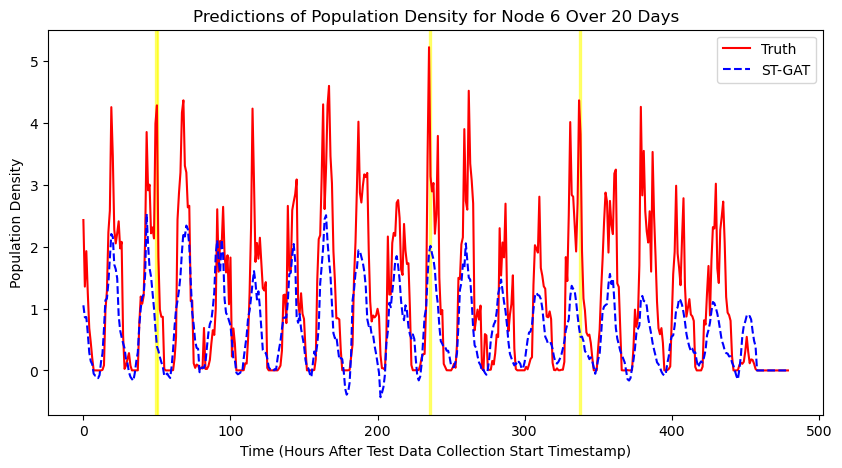

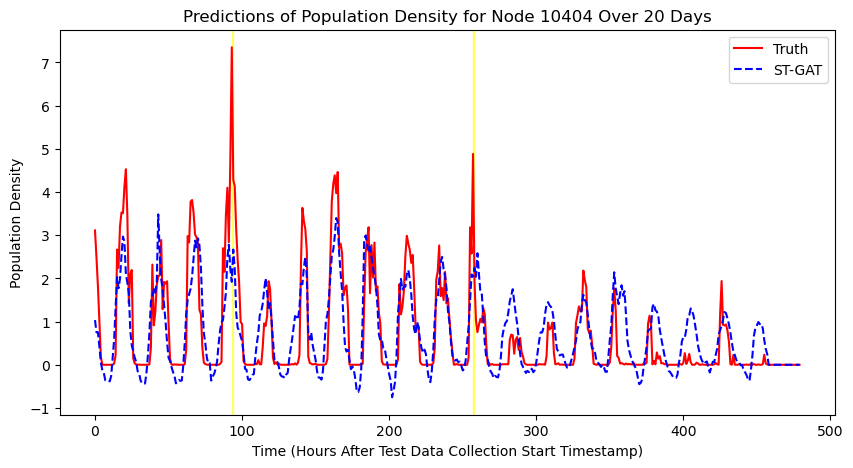

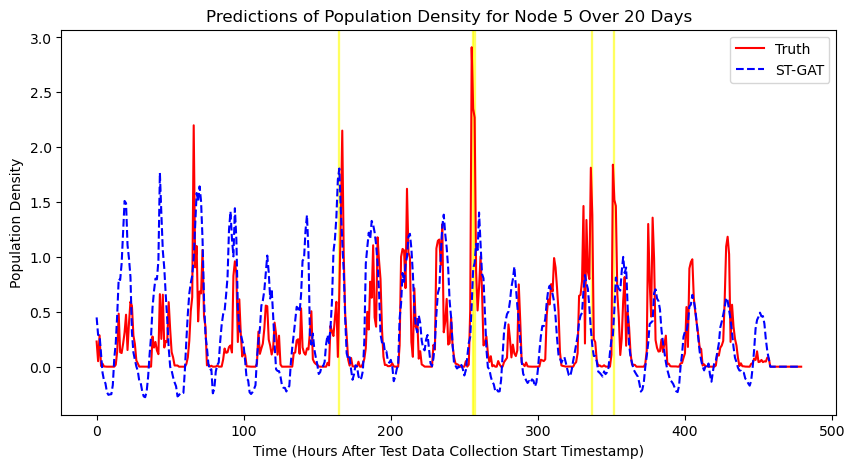

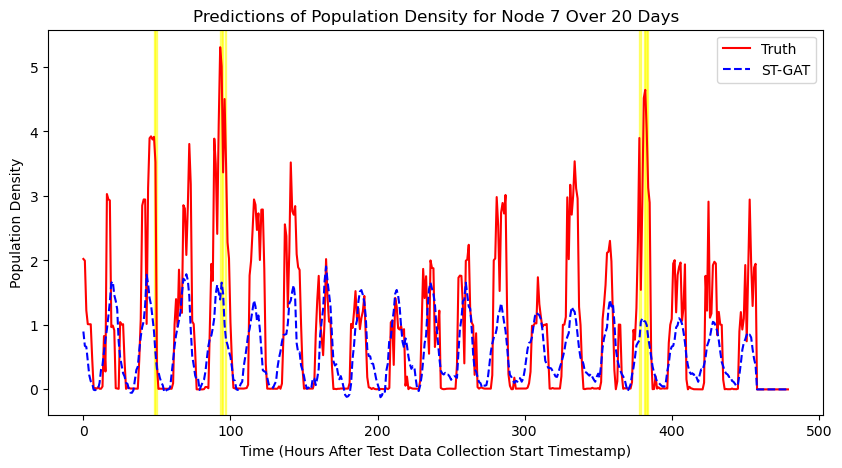

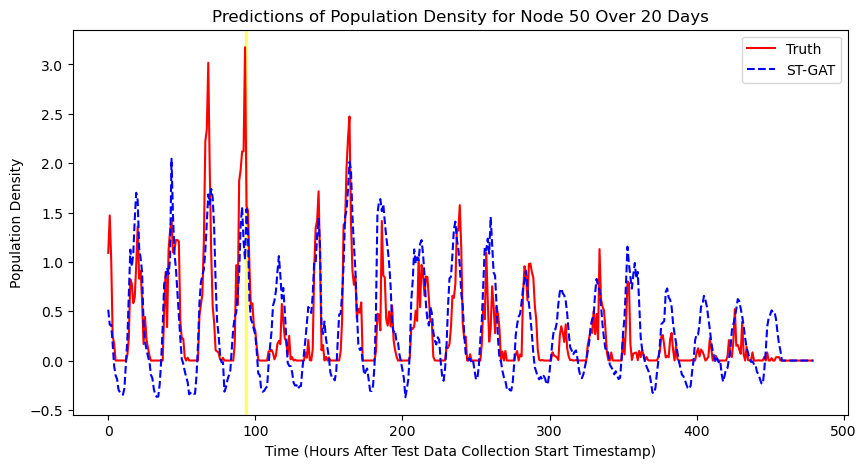

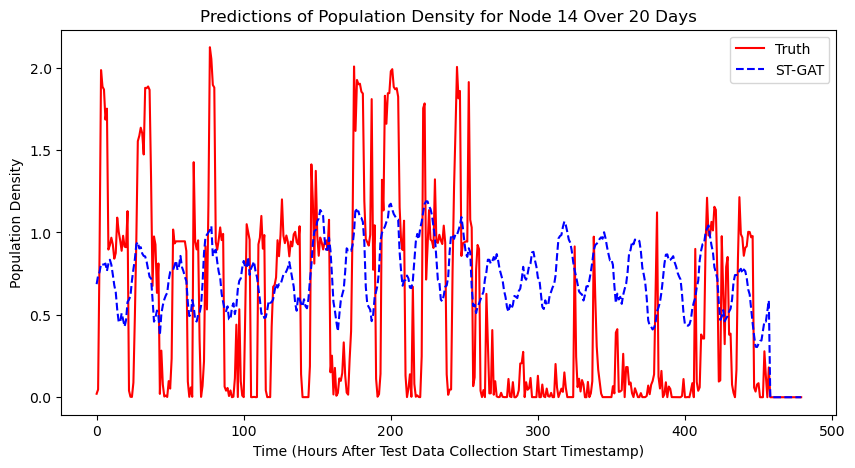

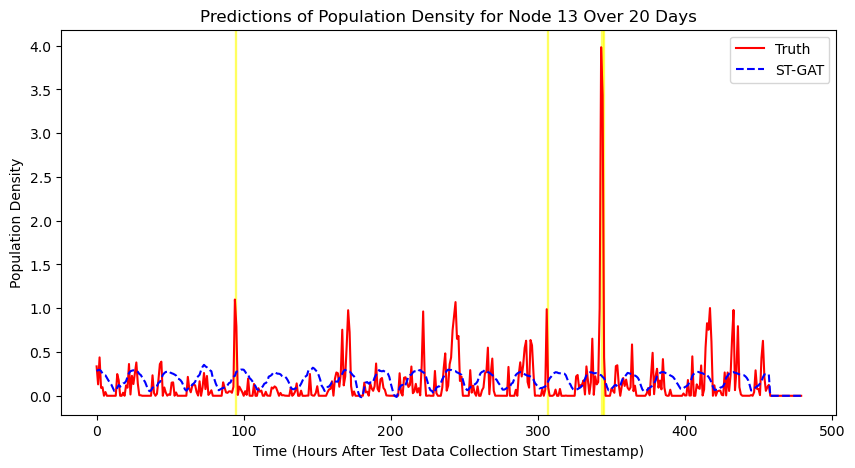

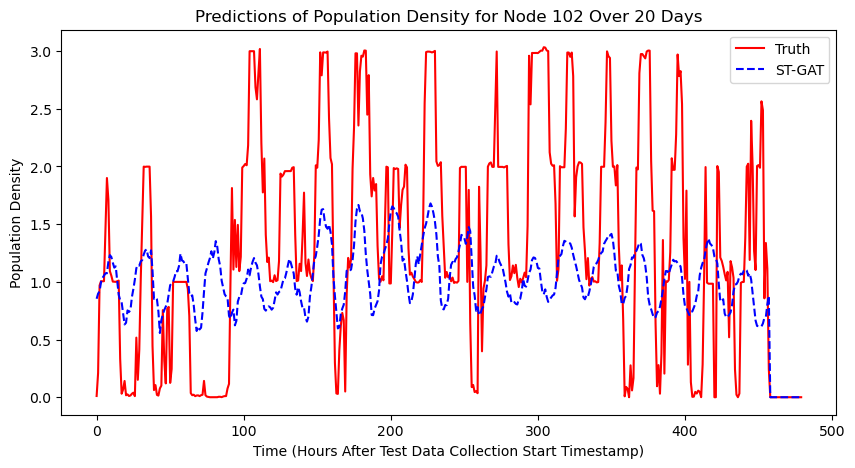

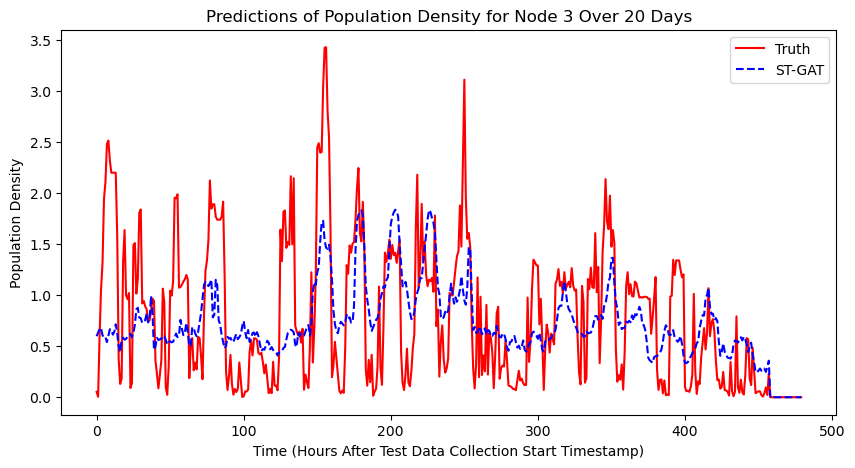

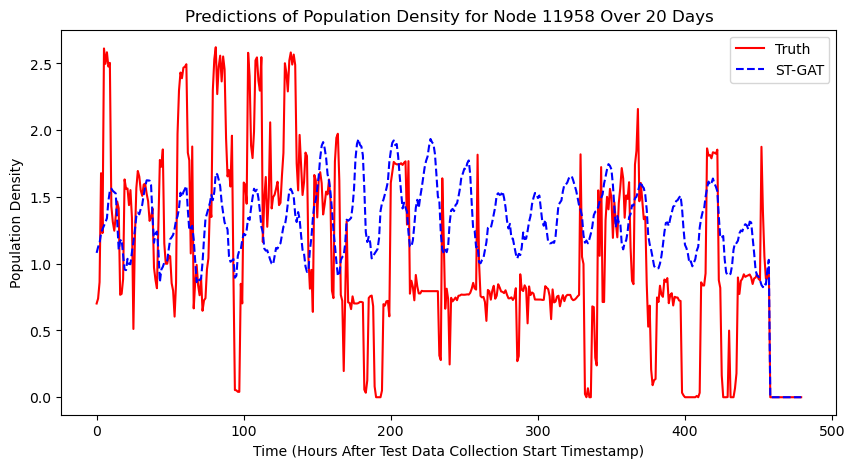

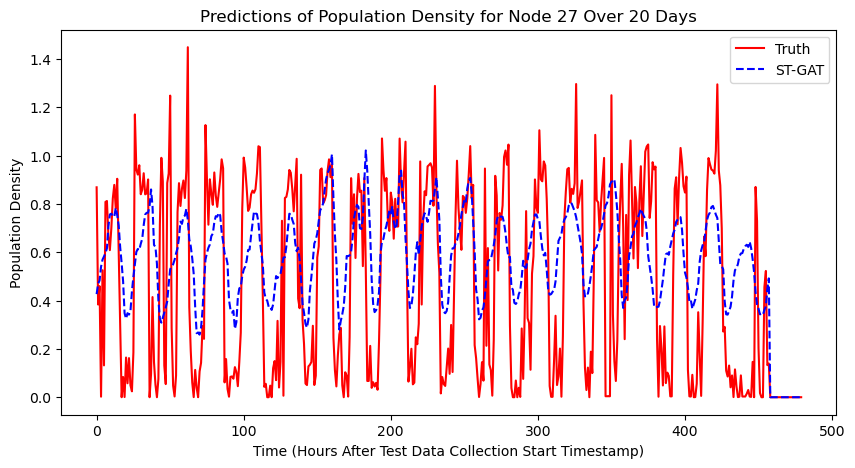

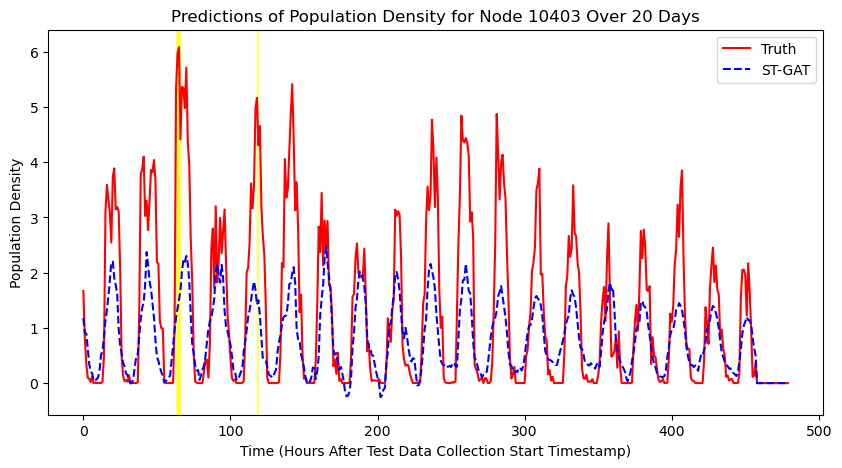

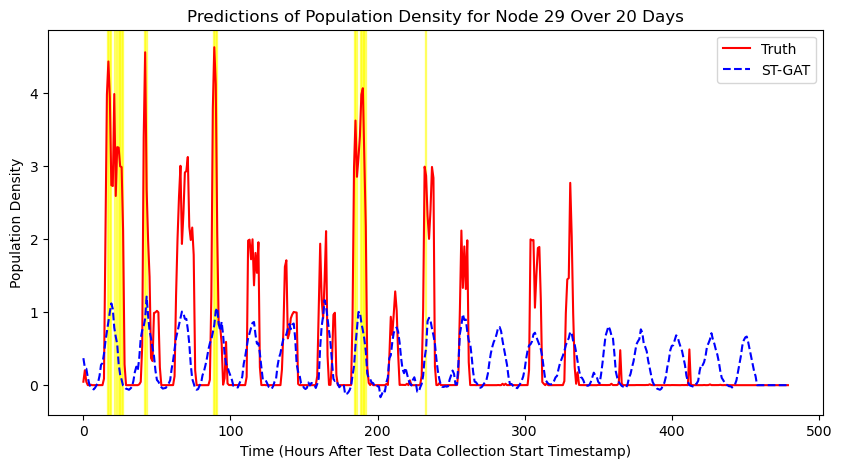

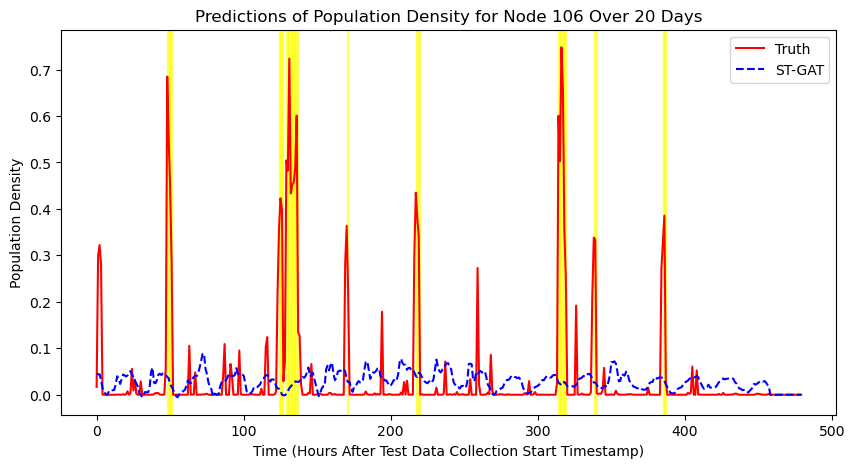

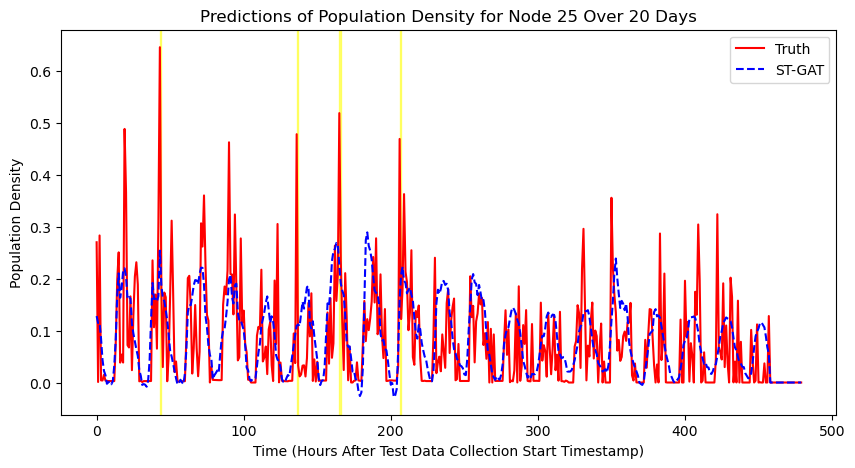

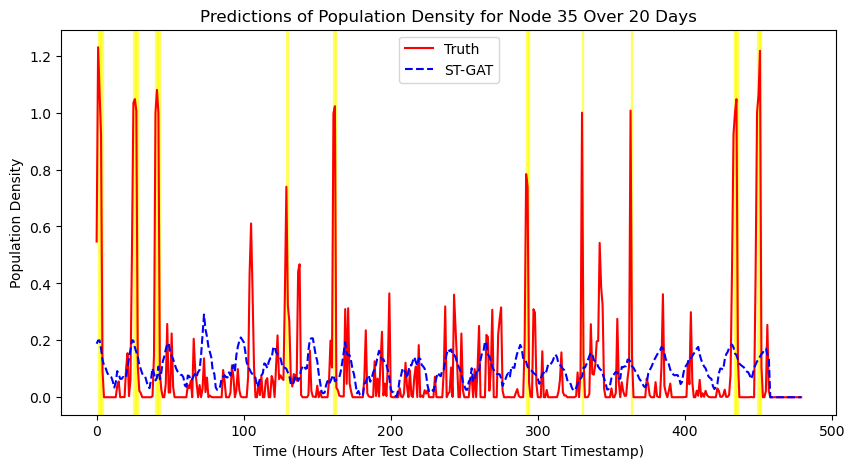

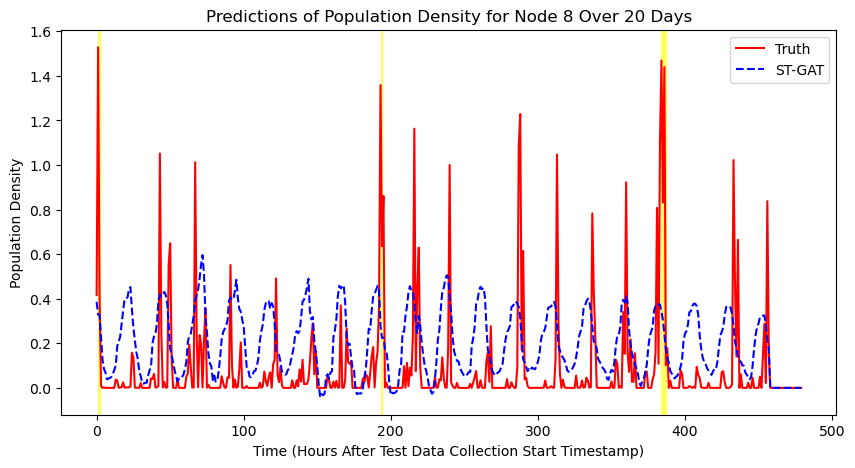

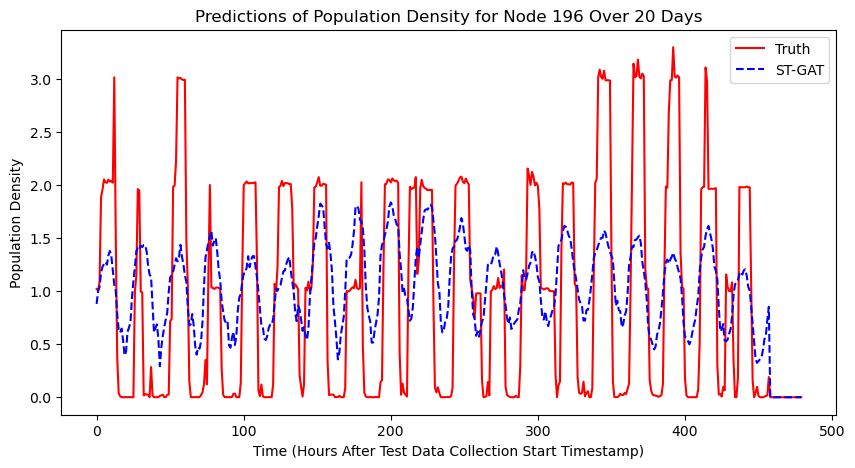

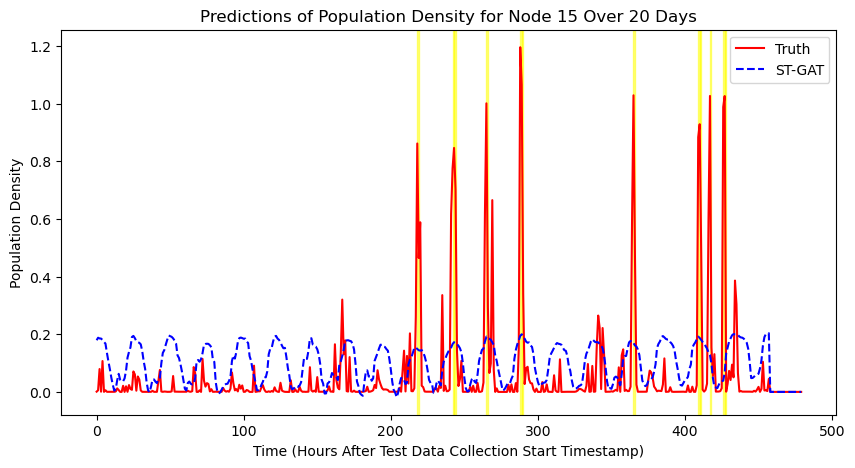

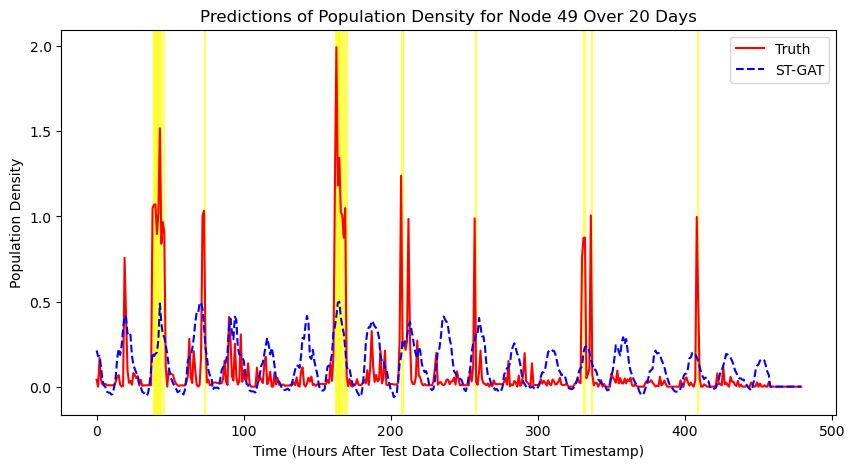

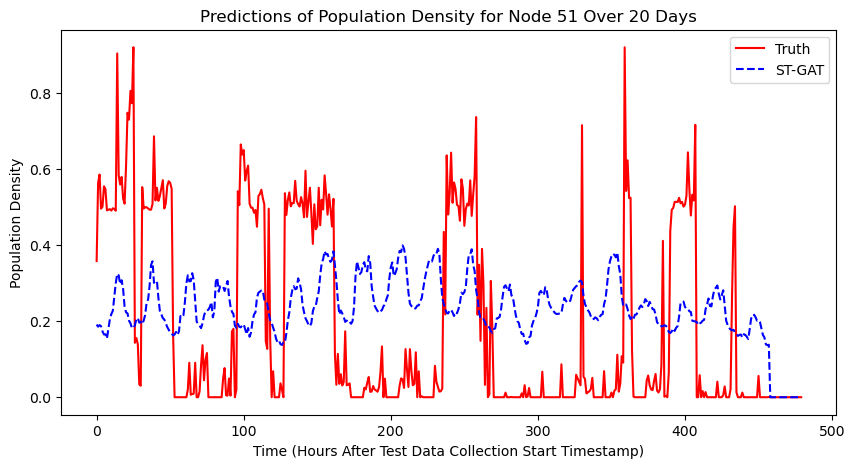

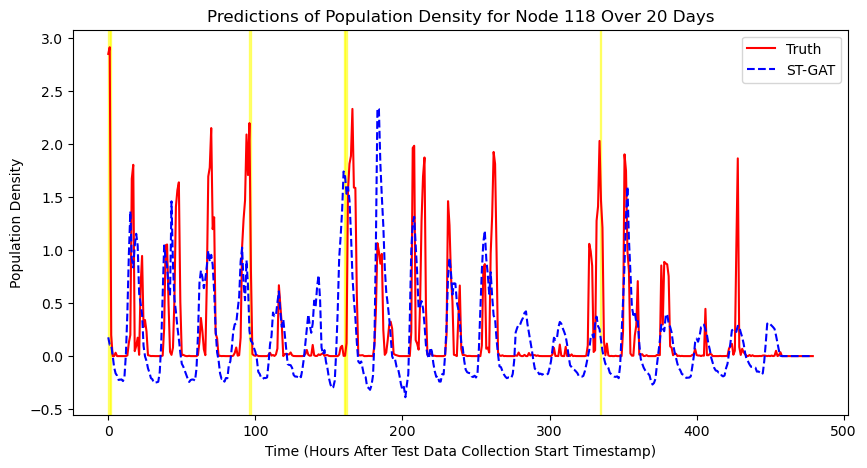

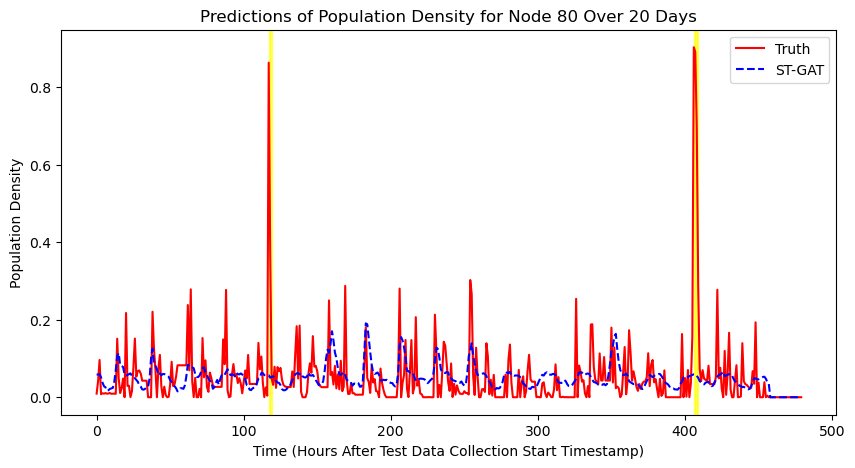

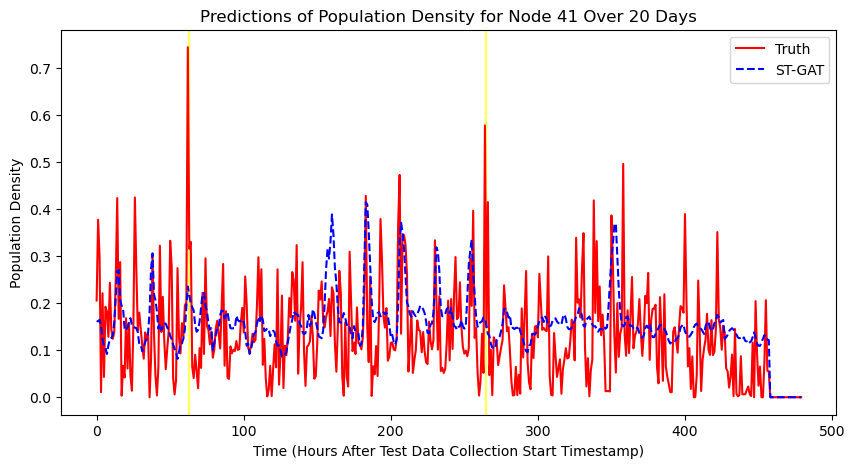

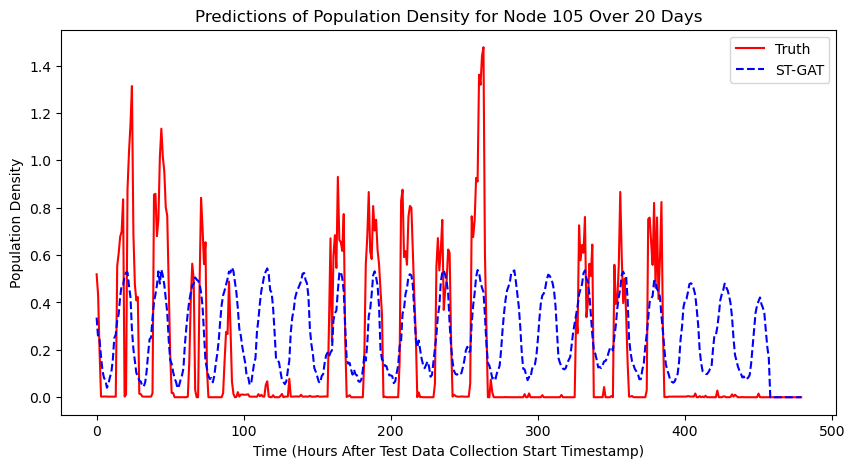

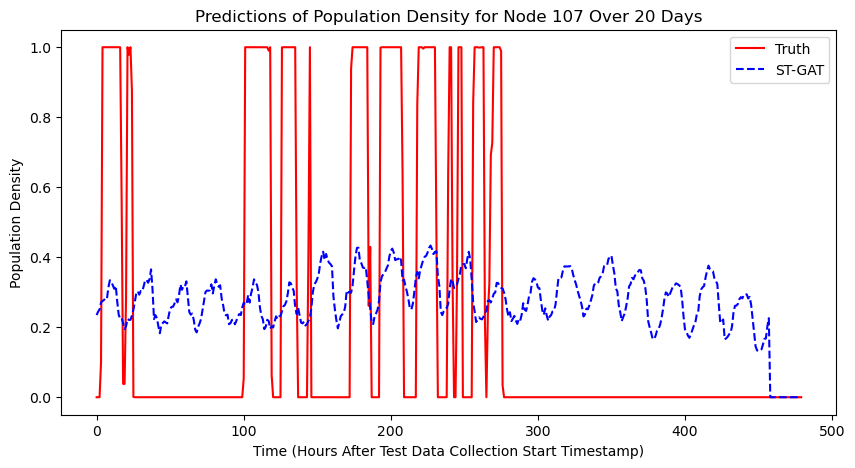

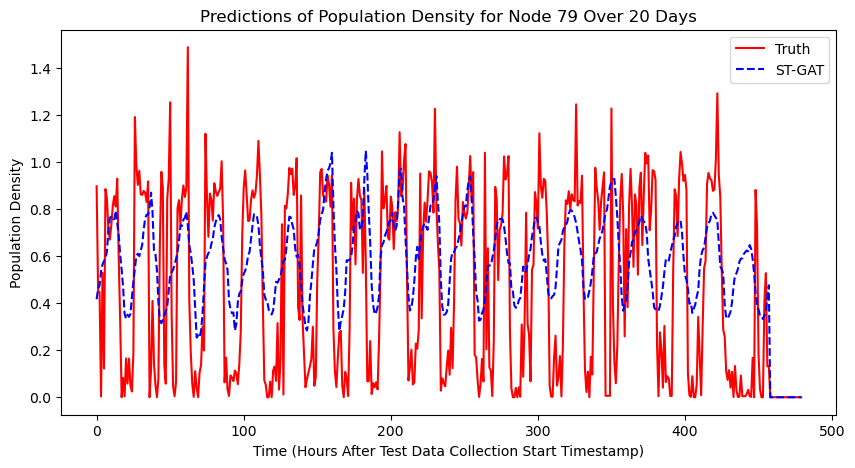

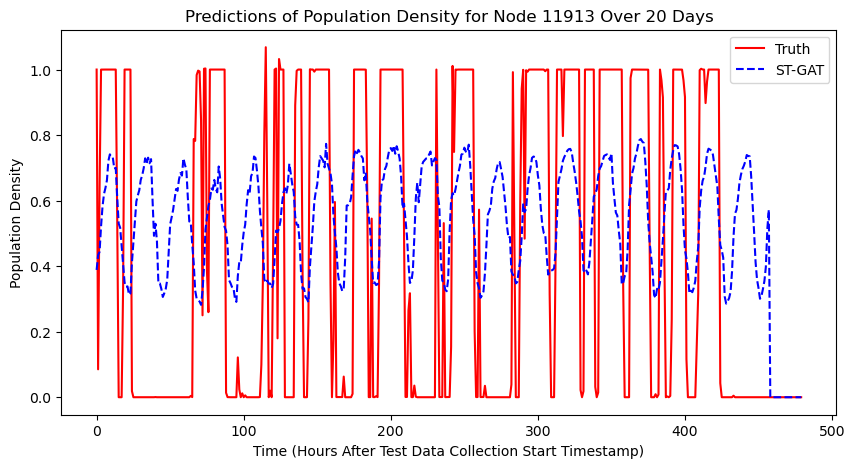

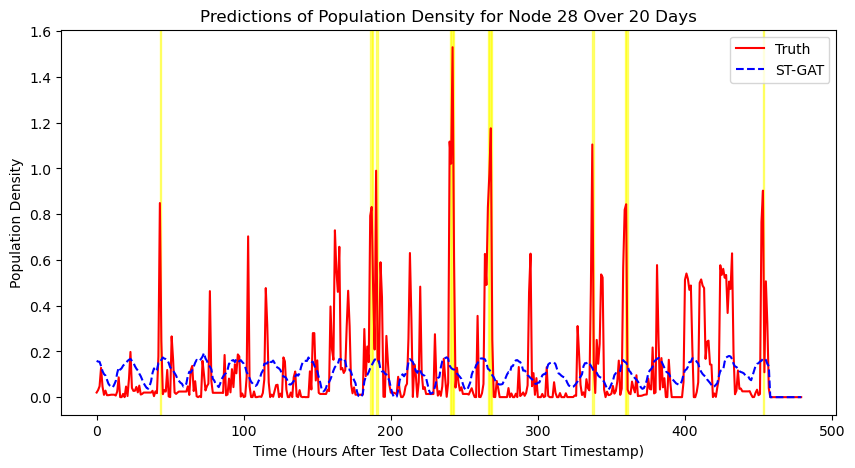

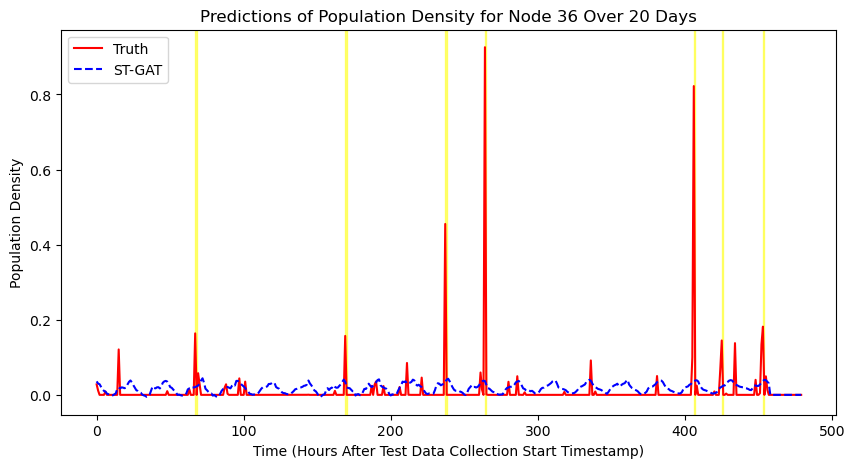

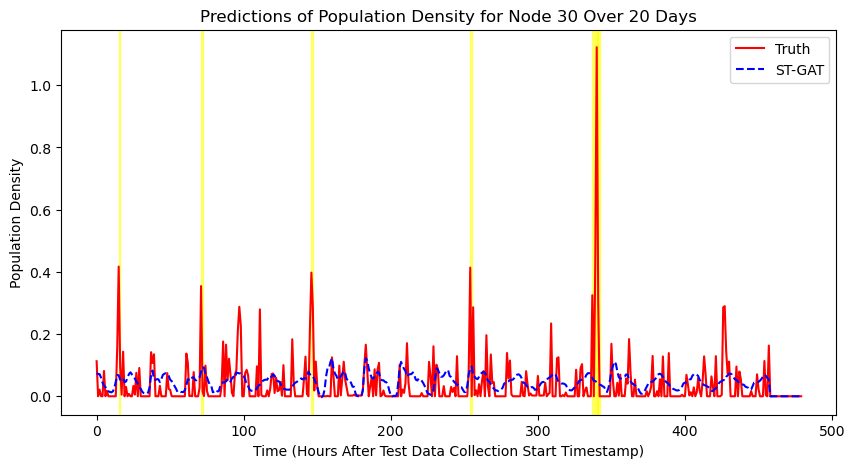

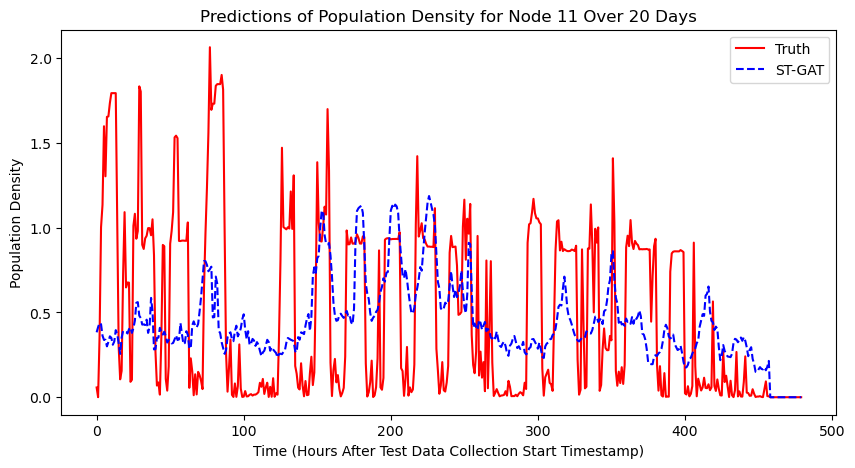

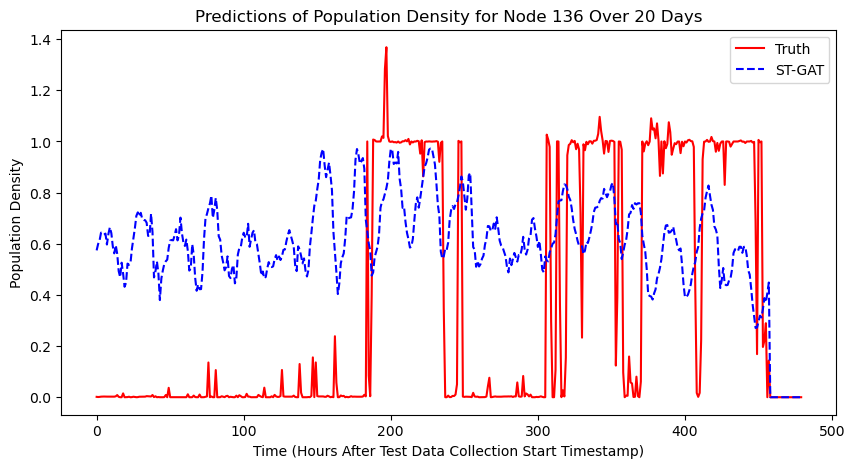

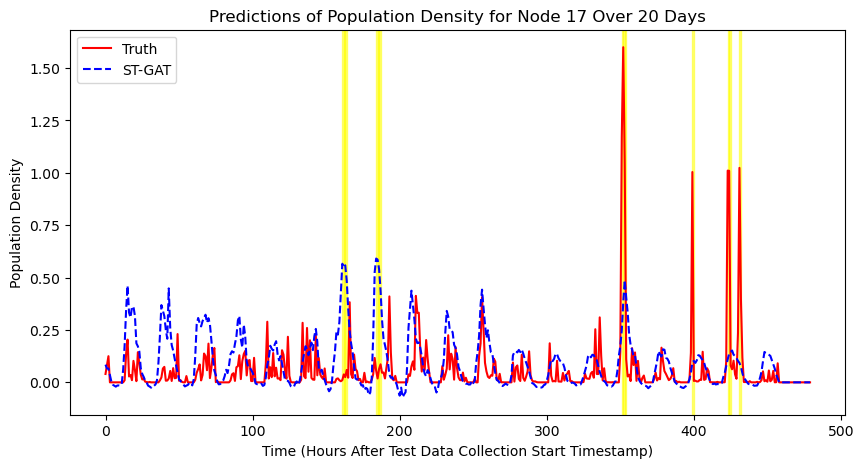

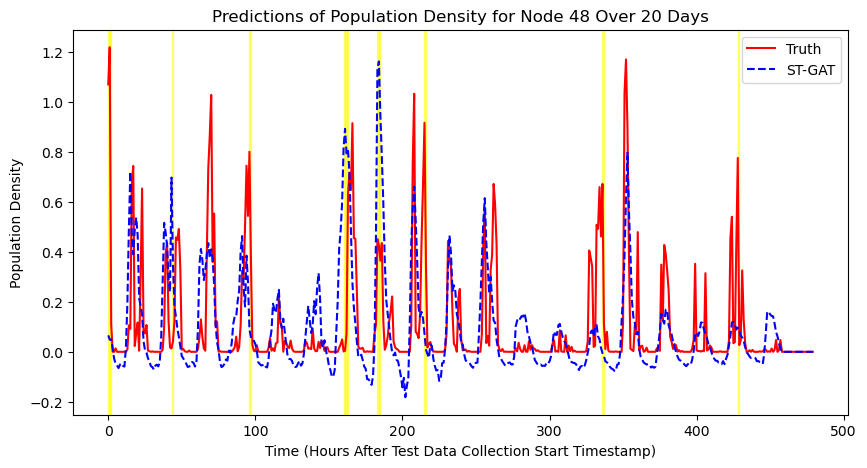

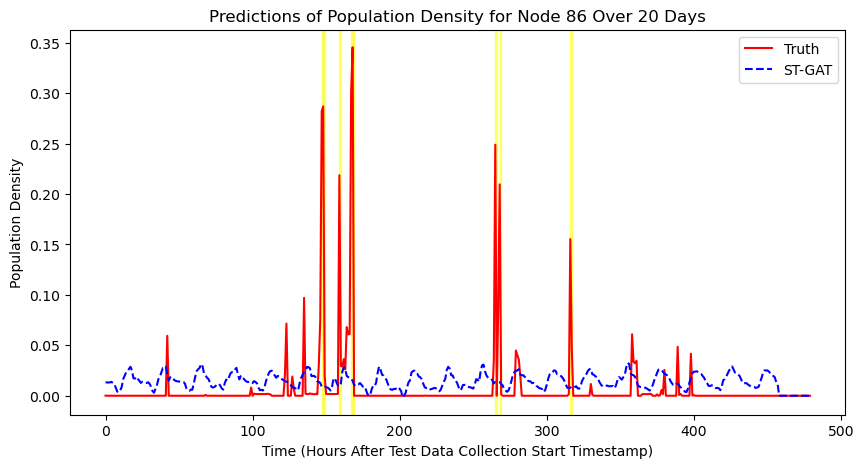

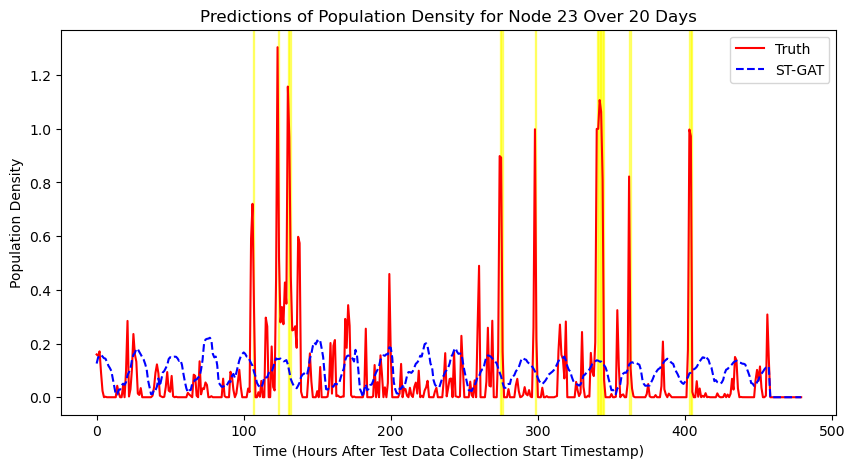

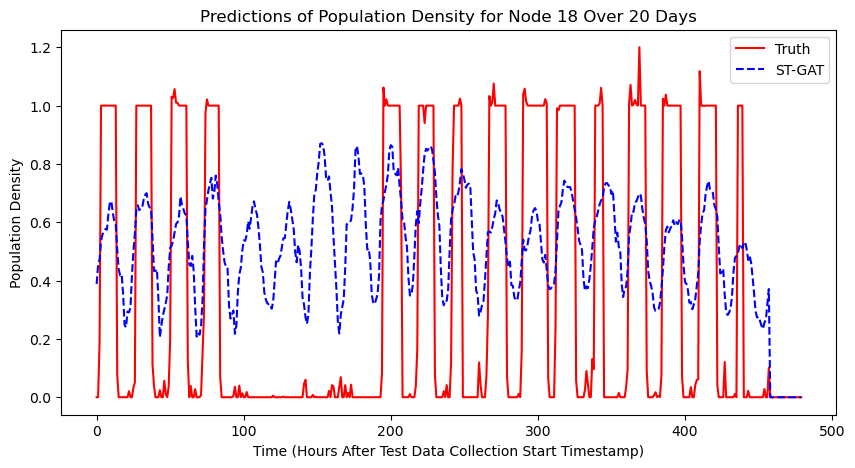

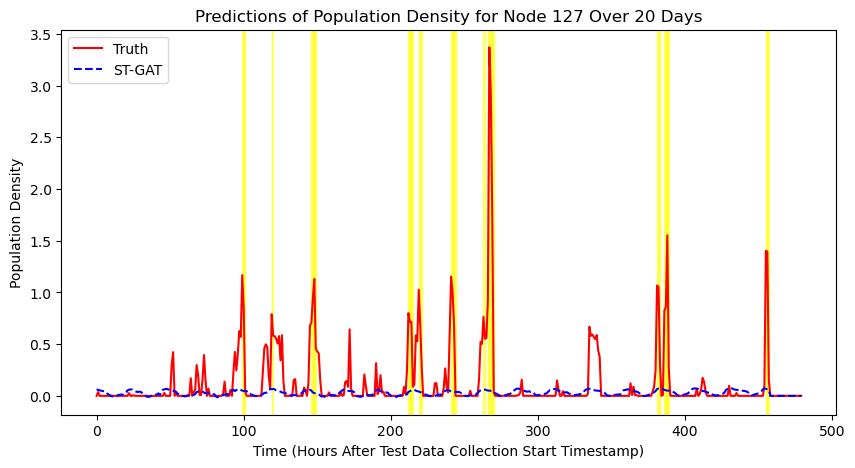

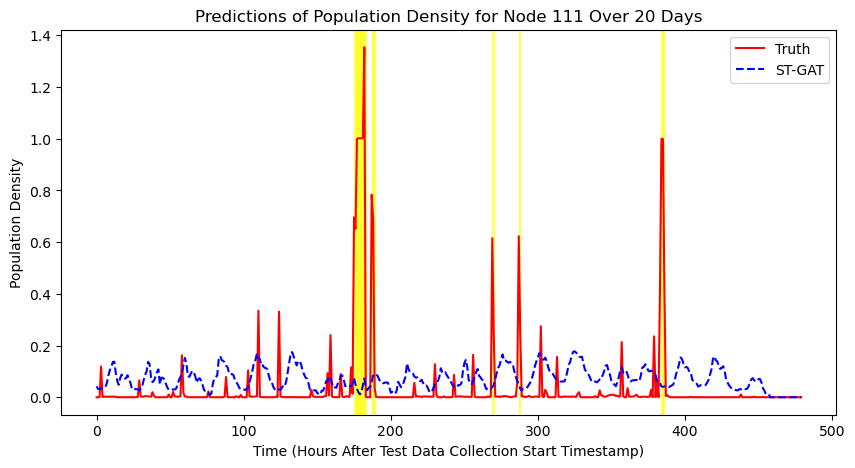

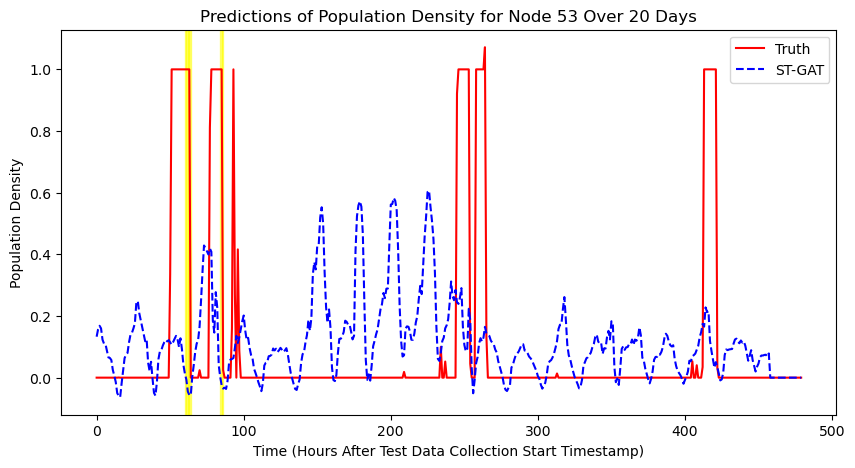

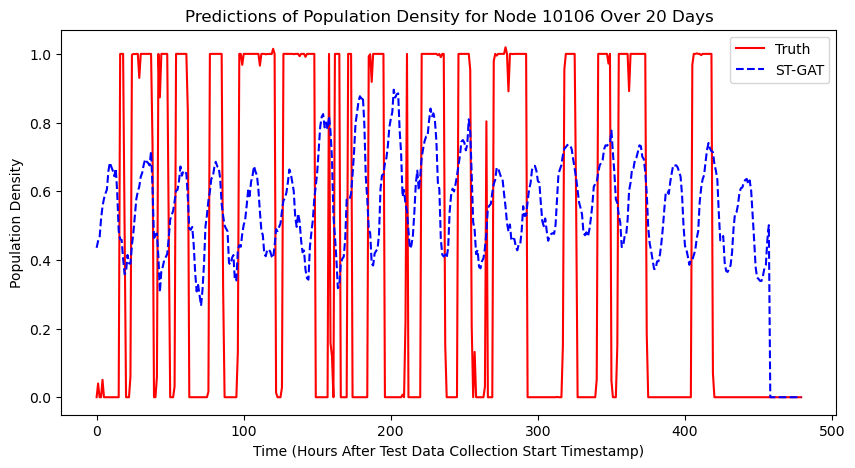

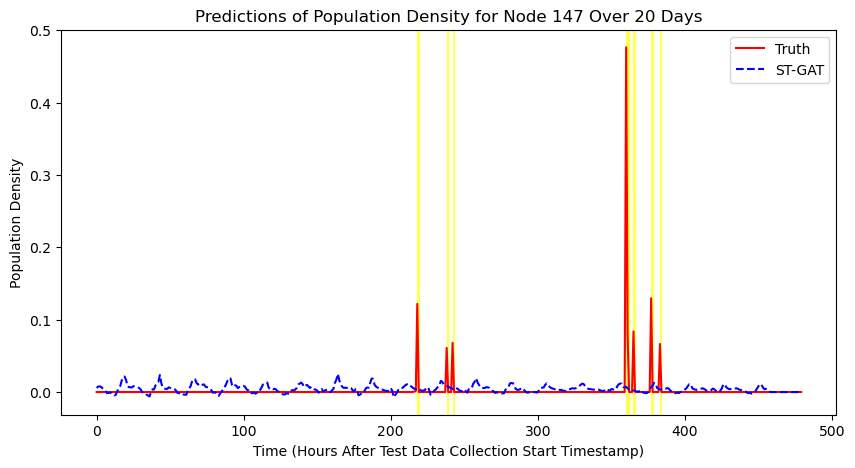

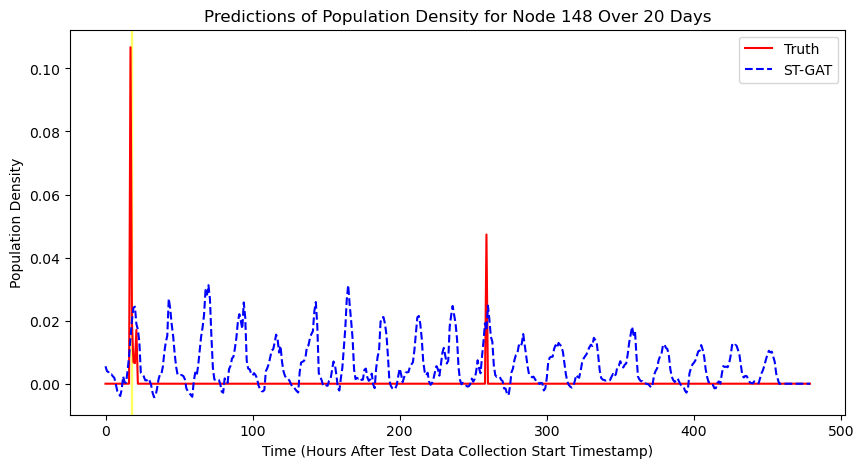

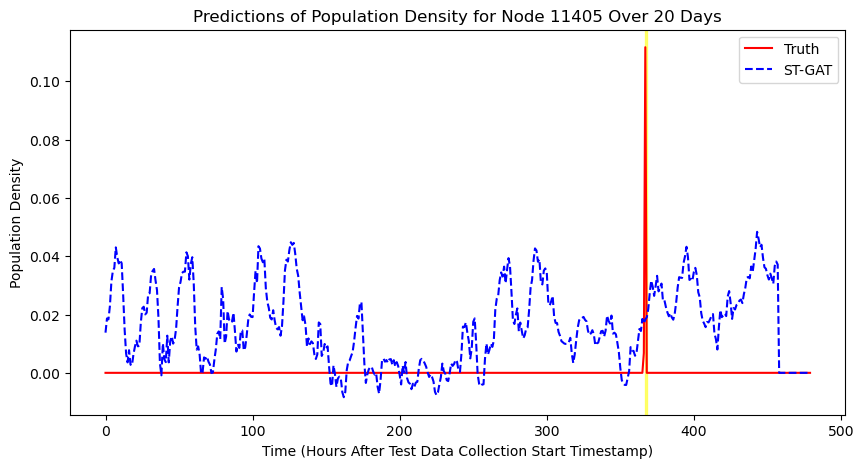

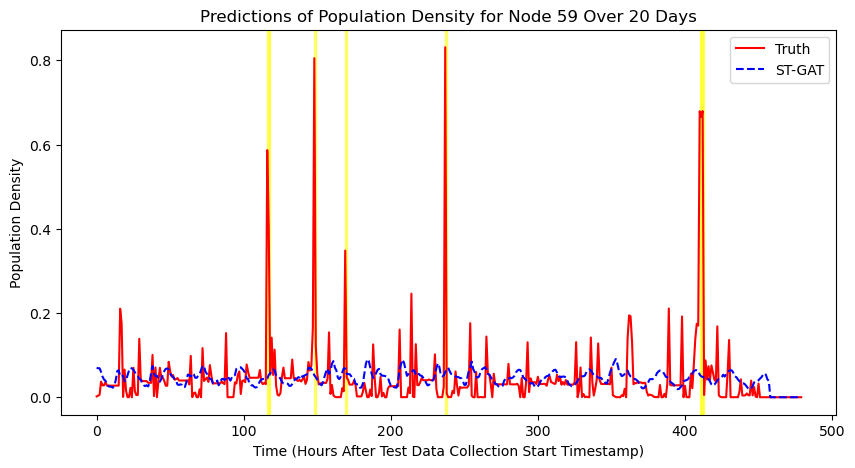

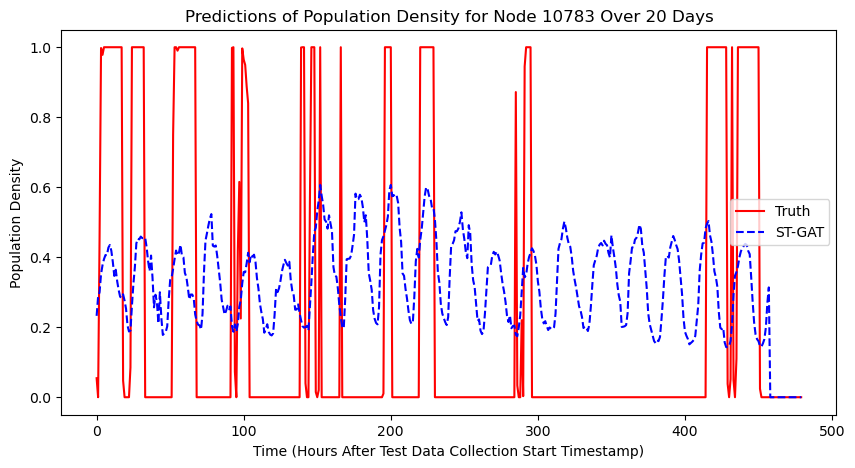

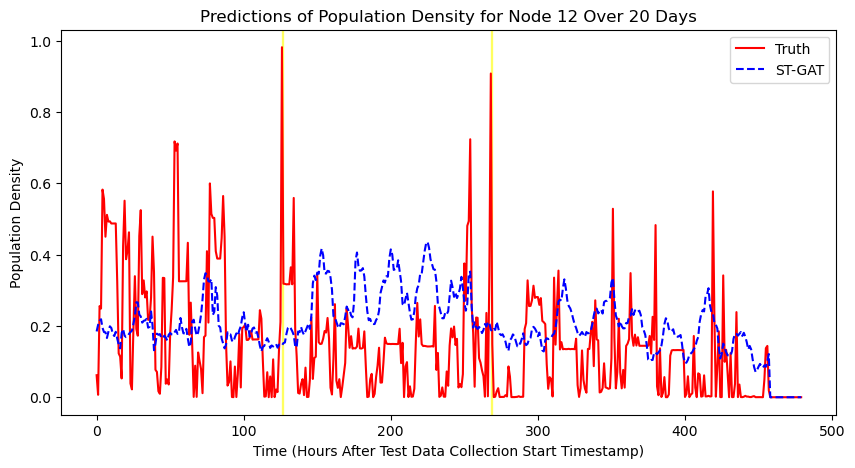

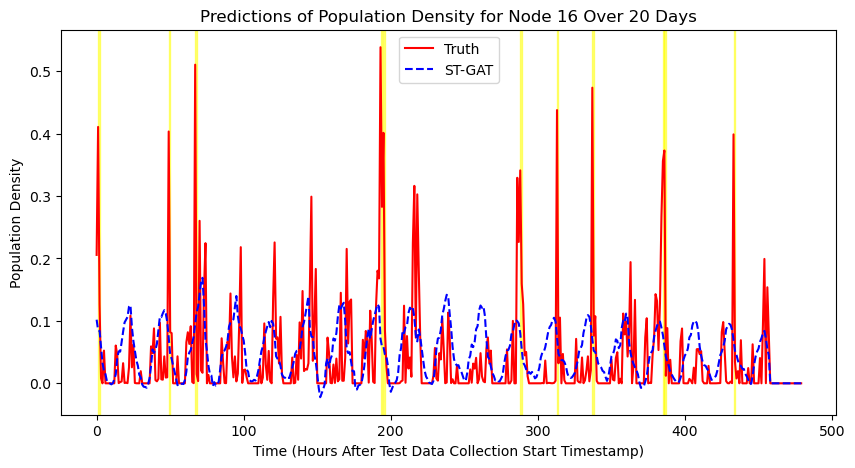

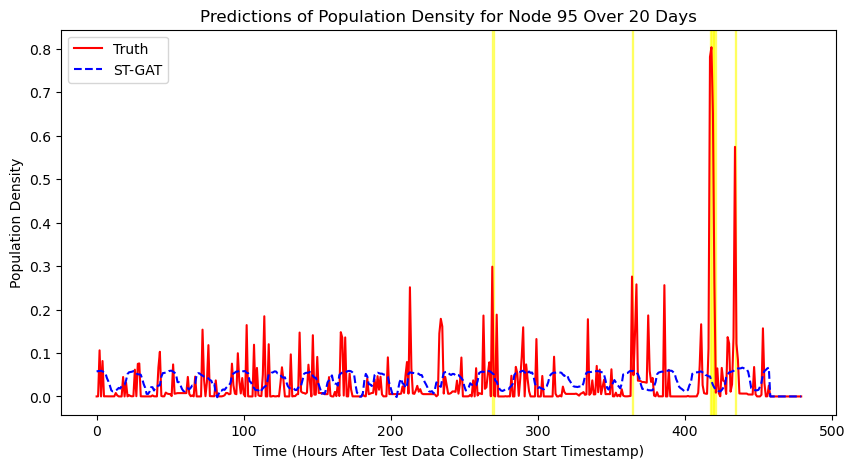

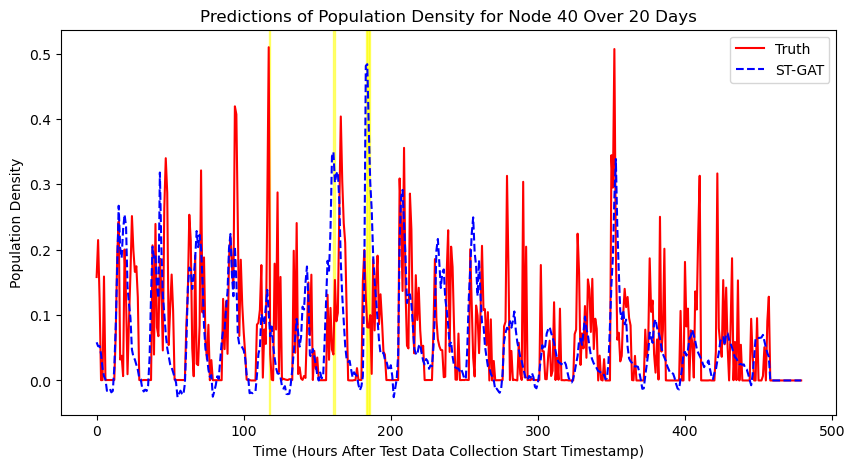

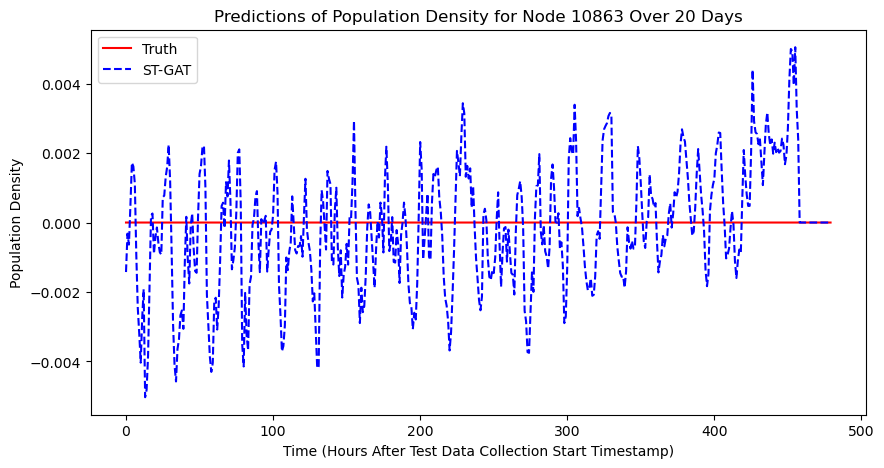

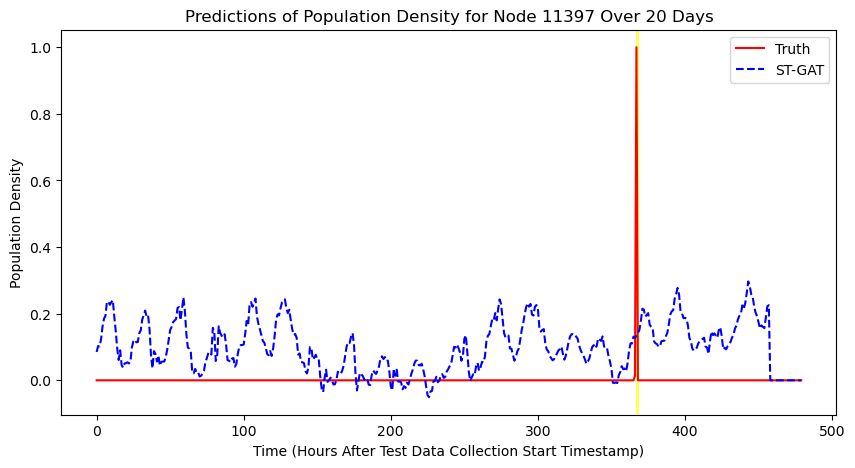

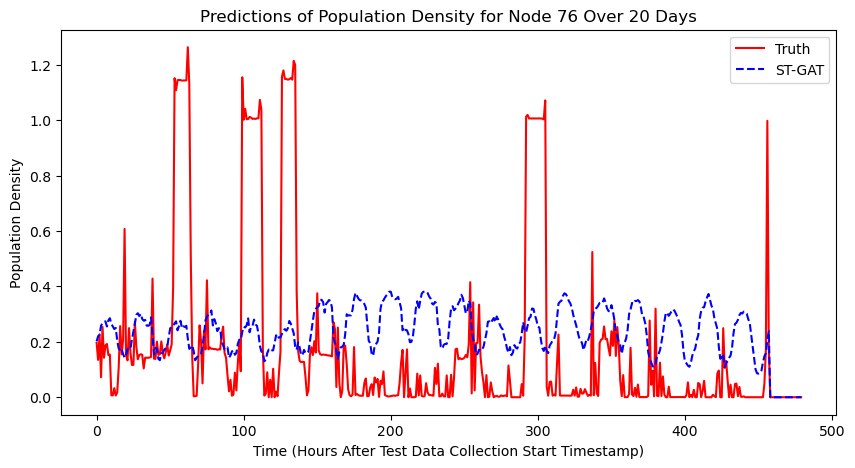

In [19]:
# NOTE Set this to True to plot all 9 hours of predictions
# If False, it will just plot the first hour of each prediction
full_prediction_plot = False

anomaly_log = []

def plot_predictions_for_poi_rank_n(n):
    """
    Plot the predictions for the POI ranked at position n
    
    Highlight in yellow anomalies where the ground truth is either
    abnormally higher or lower than the predictions for one hour ahead
    
    ARG n: Rank of the POI (0-indexed)
    """
    selected_rank = n
    prediction_node_index = sorted_indices[selected_rank]
    node_label = significant_pois[selected_rank]
    f = visualizations.predictions.plot_prediction if full_prediction_plot is False else visualizations.predictions.plot_prediction_full
    anomaly_indices = f(
        test_dataloader,
        y_pred,
        y_truth,
        prediction_node_index,
        node_label,
        selected_rank,
        config,
        anomaly_threshold_multiplier=anomaly_threshold_multiplier
    )
    dt_index = dataset.graph_timestamps[anomaly_indices]
    anomaly_timestamps = pd.to_datetime(dt_index, format="%Y-%m-%dT-%H-%M").astype(str)
    anomaly_timestamps = np.array(np.insert(anomaly_timestamps, 0, str(node_label)))
    anomaly_log.append(anomaly_timestamps)

for i in range(n_top_pois):
    plot_predictions_for_poi_rank_n(i)

with open("./output/anomaly_log.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(anomaly_log)  # Writes each list as a separate row

print("Detected anomalies logged to ./output/anomaly_log.csv")